## GPT4 Response Parsing

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
def extract_spans(x: str):
    x = x.strip()
    # Spans are either usually enclosed within single quotes. Multiple spans are separated by a comma like: 'disinterested in a lot of things', 'further disinterest in activities or work or study' 
    # However there are some exceptions.
    # Some spans have contractions like 'I'm not sure' which are enclosed within single quotes. We need to handle this.
    # Some spans have commas within them. We need to handle this.
    # Some spans are embedded in the middle of regular text like: Based on 'overwhelmed', might indicate sleep issues.
    # replace all the single quotes sandwiched between two characters between a-z or A-Z with a double quote
    x = re.sub(r"([a-zA-Z])'([a-zA-Z])", r"\1`\2", x)
    regex = r"'([^']*)'"
    # Above regex is thrown off by contractions. So we need to handle them separately. Use the comma that follows the single quote or the $ to identify the end of the span.
    y =  re.findall(regex, x)
    # replace back all the double quotes sandwiched between two characters (a-z or A-Z) with a single quote
    y = [re.sub(r"([a-zA-Z])`([a-zA-Z])", r"\1'\2", i) for i in y]
    if y == []: return x
    return y
    
test_cases = ["'I have been depressed over the last two weeks.', 'I have been feeling very low lately.', 'I have been very tearful and just generally in a low mood.'", 
              "No explicit mention, but states 'even though I am getting enough sleep', implying no significant sleep issues", 
              "'just want to sleep', indicates a tendency towards hypersomnia.", 
              "Based on 'lack of sleep' and 'constantly depressed and down', fatigue is likely", 
              "'Everything feels pointless', 'My existence feels pointless, like I don't serve a purpose'", 
              "'It takes me significantly longer to do very simple tasks than I use to.', 'Sometimes, when no one is watching, I struggle to walk. As if there's some heavy weight holding my legs back.'",
              "'I have no motivation to 'upskill', 'better myself' or 'make myself more marketable''", #694 user id
              "'I have felt depressed due to my partner's redundancy', 'I have been feeling depressed about our relationship too'", 
              "Not explicitly mentioned, but no indication of fatigue"
              ]


In [3]:
def response_parser(response):
    """
    Split the response into Steps, extract the symptoms, category and score.
    Works for simple PHQ9 prompt template
    """
    try:
        response_json = eval(response.replace('```json', '').replace('```', ''))
    except:
        print ('Error in parsing response')
        return {}
        
    if not isinstance(response_json, dict):
        return {}
    
    ITEMS = ['Anhedonia', 'Depressed Mood', 'Insomnia or Hypersomnia', 'Fatigue', 'Poor appetite or overeating', 'Worthlessness or Guilt', 'Difficulty concentrating', 'Psychomotor agitation or retardation', 'Suicidal ideation']
    ITEMS_UNDERSCORED = {i:i.replace(' ', '_') for i in ITEMS}
    
    phq9_items = {}
    
    for item, item_list in response_json['STEP 1'].items():
        if item not in ITEMS_UNDERSCORED:
            continue
        phq9_items[item] = {'scores': [], 'reasons': [], 'isInferred': 0}
        phq9_items[item]['reasons'].append(item_list[0])
        # if item_list[1] in [-1, 'null', 'Not Mentioned', 'N/A', 'Not Evaluated', 'Not evaluated', 'Not mentioned']:
        #     phq9_items[item]['scores'].append(0)
        # elif item_list[1] == 0 and ("no explicit" in item_list[0].lower() or "not mentioned" in item_list[0].lower()):
        #     continue
        # else:
        phq9_items[item]['scores'].append(int(item_list[1]))



    for item, item_list in response_json['STEP 2'].items():
        if item not in phq9_items:
            phq9_items[item] = {'scores': [], 'reasons': [], 'isInferred': 1}
        phq9_items[item]['reasons'].append(item_list[0])
        phq9_items[item]['scores'].append(int(item_list[1]))
        phq9_items[item]['isInferred'] = 1

    if len(response_json['STEP 3']['Final']) == 3:
        score = response_json['STEP 3']['Final'][1]
        category = response_json['STEP 3']['Final'][2]
    else:
        score = response_json['STEP 3']['Final'][0]
        category = response_json['STEP 3']['Final'][1]
    
    if isinstance(score, str):
        score = response_json['STEP 3']['Final'][0].replace('Combined Score: ', ' ').strip()    
    score = float(score)        
    
    if category.startswith('Category: '):
        category = category.replace('Category: ', '').strip()
        
    underscore_dict = {}    
    for item, item_underscored in ITEMS_UNDERSCORED.items():
        if item in phq9_items:
            underscore_dict['score_'+item_underscored] = sum(phq9_items[item]['scores'])
            underscore_dict['spans_'+item_underscored] = extract_spans(' '.join(phq9_items[item]['reasons']))
            underscore_dict['isInferred_'+item_underscored] = phq9_items[item]['isInferred']
        else:
            print ('Missing {}'.format(item))
            underscore_dict['score_'+item_underscored] = 0
            underscore_dict['spans_'+item_underscored] = []
            underscore_dict['isInferred_'+item_underscored] = -1
    
    underscore_dict['score'] = score
    underscore_dict['category'] = category
    underscore_dict['symptoms'] = phq9_items
    
    return underscore_dict 

In [4]:
RESPONSE_FILE_PATH = "/cronus_data/avirinchipur/reasoning_for_psych/expts/responses/expt_gpt-4-1106-preview.dep_list_phq9items_score_classify2_editted.csv"

In [5]:
response_df = pd.read_csv(RESPONSE_FILE_PATH)
response_df.head()

,user_id,input_text,target_value,response_text_original,response_text,user_text
0,1,"[{'role': 'user', 'content': 'Your task is to ...",0,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...","Over the past two weeks, I have not been depre..."
1,2,"[{'role': 'user', 'content': 'Your task is to ...",17,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...",I don't think I have felt depressed. I'm not f...
2,3,"[{'role': 'user', 'content': 'Your task is to ...",21,"```json\n{\n ""STEP 1"": {\n ""Depresse...","```json\n{\n ""STEP 1"": {\n ""Depresse...",I have been depressed because I am worried abo...
3,4,"[{'role': 'user', 'content': 'Your task is to ...",13,"```json\n{\n ""STEP 1"": {\n ""Depresse...","```json\n{\n ""STEP 1"": {\n ""Depresse...",Over the past 2 weeks i have been feeling depr...
4,5,"[{'role': 'user', 'content': 'Your task is to ...",9,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...",yes very much just seem everything is getting ...


In [6]:
response_df.shape

(956, 6)

In [7]:
# Removing bad response
str_to_match = 'Please answer the question by typing at least a paragraph below that indicates whether you have been worried or not. Try to weigh the strength and the number of aspects that describe if you have been worried or not so that they reflect your overall personal state of worry. For example, if you have been worried then write more about aspects describing this, and if you have not been worried then write more about aspects describing that. \n\nWrite about those aspects that are most important and meaningful to you.'
response_df = response_df[response_df['user_text'] != str_to_match]

In [8]:
user_text, example_response_text = response_df.sample(frac=1.0)[['user_text', 'response_text']].values[0]
print (user_text)
print (example_response_text)

I have been working from for more than 4 months. Personally I hate working from home and it makes me feel depressed. The last week was a complete disaster.  We have one toddler at home, 2 months old. Trying to stick to work while having to look after the kids, It's really complicated.  Currently there's a lot of uncertanity, which makes us feel uncomfortable.
```json
{
    "STEP 1": {
        "Depressed Mood": ["'it makes me feel depressed'", "2"],
        "Difficulty concentrating": ["'Trying to stick to work while having to look after the kids'", "1"]
    },
    "STEP 2": {
        "Anhedonia": ["No explicit mention, but implied dislike for working from home", "1"],
        "Insomnia or Hypersomnia": ["No explicit mention, but having a toddler might affect sleep", "1"],
        "Fatigue": ["No explicit mention, but caring for a toddler and work stress could imply fatigue", "1"],
        "Poor appetite or overeating": ["No explicit mention", "0"],
        "Worthlessness or Guilt": ["N

In [9]:
response_df['parsed_response'] = response_df['response_text'].apply(response_parser)

In [10]:
response_df

,user_id,input_text,target_value,response_text_original,response_text,user_text,parsed_response
0,1,"[{'role': 'user', 'content': 'Your task is to ...",0,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...","Over the past two weeks, I have not been depre...","{'score_Anhedonia': 0, 'spans_Anhedonia': ['I ..."
1,2,"[{'role': 'user', 'content': 'Your task is to ...",17,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...",I don't think I have felt depressed. I'm not f...,"{'score_Anhedonia': 2, 'spans_Anhedonia': ['I ..."
2,3,"[{'role': 'user', 'content': 'Your task is to ...",21,"```json\n{\n ""STEP 1"": {\n ""Depresse...","```json\n{\n ""STEP 1"": {\n ""Depresse...",I have been depressed because I am worried abo...,"{'score_Anhedonia': 1, 'spans_Anhedonia': 'No ..."
3,4,"[{'role': 'user', 'content': 'Your task is to ...",13,"```json\n{\n ""STEP 1"": {\n ""Depresse...","```json\n{\n ""STEP 1"": {\n ""Depresse...",Over the past 2 weeks i have been feeling depr...,"{'score_Anhedonia': 2, 'spans_Anhedonia': ['no..."
4,5,"[{'role': 'user', 'content': 'Your task is to ...",9,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...",yes very much just seem everything is getting ...,"{'score_Anhedonia': 2, 'spans_Anhedonia': ['no..."
...,...,...,...,...,...,...,...
951,972,"[{'role': 'user', 'content': 'Your task is to ...",11,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...",There has been time when I have not wanted to ...,"{'score_Anhedonia': 2, 'spans_Anhedonia': ['I ..."
952,973,"[{'role': 'user', 'content': 'Your task is to ...",20,"```json\n{\n ""STEP 1"": {\n ""Depresse...","```json\n{\n ""STEP 1"": {\n ""Depresse...","I’m not sure if I’ve been depressed exactly, I...","{'score_Anhedonia': 1, 'spans_Anhedonia': ['So..."
953,974,"[{'role': 'user', 'content': 'Your task is to ...",20,"```json\n{\n ""STEP 1"": {\n ""Depresse...","```json\n{\n ""STEP 1"": {\n ""Depresse...","I haven’t felt depressed. However, I have expe...","{'score_Anhedonia': 1, 'spans_Anhedonia': 'No ..."
954,975,"[{'role': 'user', 'content': 'Your task is to ...",22,"```json\n{\n ""STEP 1"": {\n ""Anhedoni...","```json\n{\n ""STEP 1"": {\n ""Anhedoni...",I have suffered from depression since my early...,"{'score_Anhedonia': 2, 'spans_Anhedonia': ['I ..."


In [11]:
response_df[response_df['parsed_response'] == {}]

,user_id,input_text,target_value,response_text_original,response_text,user_text,parsed_response


In [12]:
parsed_response_df = pd.concat((response_df[['user_id', 'target_value']], pd.DataFrame(response_df['parsed_response'].tolist(), index=response_df.index)), axis=1)
parsed_response_df

,user_id,target_value,score_Anhedonia,spans_Anhedonia,isInferred_Anhedonia,score_Depressed_Mood,spans_Depressed_Mood,isInferred_Depressed_Mood,score_Insomnia_or_Hypersomnia,spans_Insomnia_or_Hypersomnia,...,isInferred_Difficulty_concentrating,score_Psychomotor_agitation_or_retardation,spans_Psychomotor_agitation_or_retardation,isInferred_Psychomotor_agitation_or_retardation,score_Suicidal_ideation,spans_Suicidal_ideation,isInferred_Suicidal_ideation,score,category,symptoms
0,1,0,0,[I have been interested in things as much as I...,0,0,"[Over the past two weeks, I have not been depr...",0,0,[my sleep has been pretty good.],...,1,0,No evidence of psychomotor agitation or retard...,1,0,No evidence of suicidal ideation mentioned.,1,0.0,None,"{'Anhedonia': {'scores': [0], 'reasons': [''I ..."
1,2,17,2,[I do find it hard to get pleasure out of things],0,0,[I don't think I have felt depressed],0,0,No explicit mention; estimated based on availa...,...,1,0,No explicit mention; estimated based on availa...,1,0,No explicit mention; estimated based on availa...,1,3.0,Mild,"{'Anhedonia': {'scores': [2], 'reasons': [''I ..."
2,3,21,1,"No explicit mention, but depression often redu...",1,2,[I have been depressed],0,1,"No explicit mention, but stress about job loss...",...,1,1,"No explicit mention, but depression can manife...",1,0,No explicit mention of suicidal thoughts or be...,1,9.0,Moderate,"{'Depressed Mood': {'scores': [2], 'reasons': ..."
3,4,13,2,[not being able to go out made it worse],0,2,[feeling depressed],0,1,"No explicit mention, but depression often affe...",...,1,0,"No explicit mention, but feeling worse could i...",1,0,No explicit mention of suicidal thoughts or be...,1,7.0,Mild,"{'Depressed Mood': {'scores': [2], 'reasons': ..."
4,5,9,2,[no money to get out and see friends],0,2,[everything is getting on top of me at the mom...,0,1,[just work and sleep],...,1,1,Estimated based on the lack of energy and feel...,1,0,"No evidence in text, estimated as absent",1,11.0,Moderate,"{'Anhedonia': {'scores': [2], 'reasons': [''no..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,972,11,2,[I have not wanted to get dressed or get out o...,0,2,Based on the lack of desire to socialize and d...,1,1,"No explicit mention, but difficulty getting ou...",...,1,1,"No explicit mention, but not wanting to get dr...",1,0,"No information provided, estimated as absent d...",1,10.0,Moderate,"{'Anhedonia': {'scores': [2], 'reasons': [''I ..."
952,973,20,1,[Some days I feel what’s the point of much rea...,1,1,[I have definitely been feeling down],0,1,Estimated based on reported mood and fatigue,...,1,1,Estimated based on difficulty doing normal dai...,1,0,"No explicit mention, estimated as none",1,8.0,Moderate,"{'Depressed Mood': {'scores': [1], 'reasons': ..."
953,974,20,1,"No explicit mention, but mood swings may affec...",1,0,[I haven’t felt depressed],0,0,"No explicit mention, mood swings do not necess...",...,1,0,"No explicit mention, mood swings do not necess...",1,0,No explicit mention of suicidal thoughts or be...,1,2.0,Mild,"{'Depressed Mood': {'scores': [0], 'reasons': ..."
954,975,22,2,[I have no motivation or energy],0,2,[I cycle through feelings of complete despair],0,2,[I’m over sleeping],...,0,1,Based on the overall depressive state and lack...,1,1,"No explicit mention of suicidal thoughts, but ...",1,16.0,Moderately Severe,"{'Anhedonia': {'scores': [2], 'reasons': [''I ..."


In [13]:
ITEMS = ['Anhedonia', 'Depressed Mood', 'Insomnia or Hypersomnia', 'Fatigue', 'Poor appetite or overeating', 'Worthlessness or Guilt', 'Difficulty concentrating', 'Psychomotor agitation or retardation', 'Suicidal ideation']
ITEMS_UNDERSCORED = {i:i.replace(' ', '_') for i in ITEMS}    

In [14]:
score_columns = ['score_{}'.format(i) for i in ITEMS_UNDERSCORED.values()]    

parsed_response_df[parsed_response_df['score'] != parsed_response_df[score_columns].sum(1)][score_columns + ['score']]

,score_Anhedonia,score_Depressed_Mood,score_Insomnia_or_Hypersomnia,score_Fatigue,score_Poor_appetite_or_overeating,score_Worthlessness_or_Guilt,score_Difficulty_concentrating,score_Psychomotor_agitation_or_retardation,score_Suicidal_ideation,score
2,1,2,1,1,1,2,1,1,0,9.0
6,1,1,0,1,0,0,0,1,0,3.0
12,1,2,1,2,1,1,1,1,0,9.0
15,1,1,1,1,0,1,1,0,0,5.0
16,1,0,1,1,1,1,1,1,0,6.0
...,...,...,...,...,...,...,...,...,...,...
947,1,2,1,1,1,1,1,0,0,7.0
950,1,2,1,1,1,1,1,1,0,8.0
951,2,2,1,2,1,1,1,1,0,10.0
952,1,1,1,2,1,1,1,1,0,8.0


In [15]:
diff = parsed_response_df['score'] - parsed_response_df[score_columns].sum(1)
diff.value_counts()

 0.0    601
-1.0    333
 1.0     15
-2.0      3
 2.0      2
 3.0      1
dtype: int64

In [16]:
null_userids = parsed_response_df[parsed_response_df.score.isnull()]
null_userids

,user_id,target_value,score_Anhedonia,spans_Anhedonia,isInferred_Anhedonia,score_Depressed_Mood,spans_Depressed_Mood,isInferred_Depressed_Mood,score_Insomnia_or_Hypersomnia,spans_Insomnia_or_Hypersomnia,...,isInferred_Difficulty_concentrating,score_Psychomotor_agitation_or_retardation,spans_Psychomotor_agitation_or_retardation,isInferred_Psychomotor_agitation_or_retardation,score_Suicidal_ideation,spans_Suicidal_ideation,isInferred_Suicidal_ideation,score,category,symptoms


In [17]:
print ("Number of instances with missing estimates for items")
for item in ITEMS_UNDERSCORED.values():
    print ("{}: {}".format(item, parsed_response_df[parsed_response_df['isInferred_'+item]==-1].shape[0]))

Number of instances with missing estimates for items
Anhedonia: 0
Depressed_Mood: 0
Insomnia_or_Hypersomnia: 0
Fatigue: 0
Poor_appetite_or_overeating: 0
Worthlessness_or_Guilt: 0
Difficulty_concentrating: 0
Psychomotor_agitation_or_retardation: 0
Suicidal_ideation: 0


In [18]:
columns = ['user_id', 'user_text'] + ['{}_{}'.format(j, i) for j in ['score', 'spans', 'isInferred']  for i in ITEMS_UNDERSCORED.values()] 
columns

['user_id',
 'user_text',
 'score_Anhedonia',
 'score_Depressed_Mood',
 'score_Insomnia_or_Hypersomnia',
 'score_Fatigue',
 'score_Poor_appetite_or_overeating',
 'score_Worthlessness_or_Guilt',
 'score_Difficulty_concentrating',
 'score_Psychomotor_agitation_or_retardation',
 'score_Suicidal_ideation',
 'spans_Anhedonia',
 'spans_Depressed_Mood',
 'spans_Insomnia_or_Hypersomnia',
 'spans_Fatigue',
 'spans_Poor_appetite_or_overeating',
 'spans_Worthlessness_or_Guilt',
 'spans_Difficulty_concentrating',
 'spans_Psychomotor_agitation_or_retardation',
 'spans_Suicidal_ideation',
 'isInferred_Anhedonia',
 'isInferred_Depressed_Mood',
 'isInferred_Insomnia_or_Hypersomnia',
 'isInferred_Fatigue',
 'isInferred_Poor_appetite_or_overeating',
 'isInferred_Worthlessness_or_Guilt',
 'isInferred_Difficulty_concentrating',
 'isInferred_Psychomotor_agitation_or_retardation',
 'isInferred_Suicidal_ideation']

In [19]:
parsed_response_df2 = pd.concat((response_df[['user_id', 'user_text']], pd.DataFrame(response_df['parsed_response'].tolist(), index=response_df.index)), axis=1)
# parsed_response_df2[columns].to_csv('/chronos_data/avirinchipur/reasoning_for_psych/expts/parsed_responses/expt_gpt-4-1106-preview.dep_list_phq9items_score_classify2_editted_unified.csv', index=False)

In [20]:
for i in ITEMS_UNDERSCORED.values():
    inferred_rows = parsed_response_df2['isInferred_{}'.format(i)] == 1
    num_rows_with_spans = parsed_response_df2[inferred_rows]['spans_{}'.format(i)].apply(lambda x: isinstance(x, list)).sum()
    print ("Inferred rows with spans for {}: N={}({}% of Inferred rows)".format(i, num_rows_with_spans, round(num_rows_with_spans*100/inferred_rows.sum(), 2)))

Inferred rows with spans for Anhedonia: N=43(9.73% of Inferred rows)
Inferred rows with spans for Depressed_Mood: N=9(26.47% of Inferred rows)
Inferred rows with spans for Insomnia_or_Hypersomnia: N=38(4.49% of Inferred rows)
Inferred rows with spans for Fatigue: N=77(10.77% of Inferred rows)
Inferred rows with spans for Poor_appetite_or_overeating: N=19(2.09% of Inferred rows)
Inferred rows with spans for Worthlessness_or_Guilt: N=69(9.53% of Inferred rows)
Inferred rows with spans for Difficulty_concentrating: N=92(10.64% of Inferred rows)
Inferred rows with spans for Psychomotor_agitation_or_retardation: N=97(10.51% of Inferred rows)
Inferred rows with spans for Suicidal_ideation: N=34(3.77% of Inferred rows)


## Correlation with self report

In [21]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import classification_report, auc, accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix

import textstat

In [22]:
# Calculate pearson correlation between target score and model score
gpt4_phq9, target_phq9 = parsed_response_df['score'].values, parsed_response_df['target_value'].values
gpt4_selfreport_pearson, p_val = pearsonr(gpt4_phq9, target_phq9)
print ("Correlation between GPT4 predicted score and target PHQ9: {} (p={})".format(round(gpt4_selfreport_pearson, 3), round(p_val, 3)))


Correlation between GPT4 predicted score and target PHQ9: 0.71 (p=0.0)


In [23]:
# Calculate pearson corr between target score and summed phq9 item scores
gpt4_phq9, target_phq9 = parsed_response_df[score_columns].sum(1), parsed_response_df['target_value'].values
gpt4_selfreport_pearson, p_val = pearsonr(gpt4_phq9, target_phq9)
print ("Correlation between GPT4 item sumed score and target PHQ9: {} (p={})".format(round(gpt4_selfreport_pearson, 3), round(p_val, 3)))


Correlation between GPT4 item sumed score and target PHQ9: 0.71 (p=0.0)


In [24]:
# Categories Mapped
x = parsed_response_df['category'].map({'None':0, 'Mild':1, 'Moderate':2, 'Moderately Severe':3, 'Severe':4})
y = parsed_response_df['target_value'].apply(lambda x: min(int(x)//5, 4))
cat_gpt4_selfreport_pearson, p_val = pearsonr(x, y)
cat_gpt4_selfreport_spearman, p_val = spearmanr(x, y)
print ("Correlation between GPT4 predicted category and target PHQ9: {} (p={})".format(round(cat_gpt4_selfreport_pearson, 3), round(p_val, 3)))
print ("Spearman Correlation between GPT4 predicted category and target PHQ9: {} (p={})".format(round(cat_gpt4_selfreport_spearman, 3), round(p_val, 3)))

Correlation between GPT4 predicted category and target PHQ9: 0.688 (p=0.0)
Spearman Correlation between GPT4 predicted category and target PHQ9: 0.702 (p=0.0)


In [25]:
print ('Classification Report')
print ('----------------------------------------------')
print (classification_report(y_pred=x, y_true=y))
print ('----------------------------------------------')
acc, bal_acc = accuracy_score(y_pred=x, y_true=y), balanced_accuracy_score(y_pred=x, y_true=y)
print ('Accuracy: {}'.format(round(acc, 3)))
print ('Balanced Accuracy: {}'.format(round(bal_acc, 3)))

Classification Report
----------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.81      0.72       212
           1       0.32      0.46      0.38       204
           2       0.20      0.38      0.26       170
           3       0.35      0.12      0.18       201
           4       0.82      0.05      0.10       168

    accuracy                           0.38       955
   macro avg       0.47      0.36      0.33       955
weighted avg       0.47      0.38      0.34       955

----------------------------------------------
Accuracy: 0.378
Balanced Accuracy: 0.362


### Item level Analysis and correlations

In [26]:
target_csv = pd.read_csv('/chronos_data/avirinchipur/reasoning_for_psych/kjell_prolific/depTextOnly.csv')
target_csv

,user_id,startdate,submitdate,dep_text,phq_score,PHQ.SQ01.,PHQ.SQ02.,PHQ.SQ03.,PHQ.SQ04.,PHQ.SQ05.,PHQ.SQ06.,PHQ.SQ07.,PHQ.SQ08.,PHQ.SQ09.,PHQ.SQ10.
0,1,2020-08-07 11:38:22,2020-08-07 11:46:22,"Over the past two weeks, I have not been depre...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,2020-08-07 11:34:31,2020-08-07 11:58:36,I don't think I have felt depressed. I'm not f...,17.0,3.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0
2,3,2020-08-07 11:36:32,2020-08-07 11:51:54,I have been depressed because I am worried abo...,21.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0
3,4,2020-08-07 12:55:26,2020-08-07 13:22:42,Over the past 2 weeks i have been feeling depr...,13.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0
4,5,2020-08-07 11:37:19,2020-08-07 12:04:52,yes very much just seem everything is getting ...,9.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,972,2020-08-07 11:45:11,2020-08-07 12:02:58,There has been time when I have not wanted to ...,11.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0
959,973,2020-08-07 13:32:04,2020-08-07 13:45:57,"I’m not sure if I’ve been depressed exactly, I...",20.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,3.0,0.0,2.0
960,974,2020-08-07 12:52:04,2020-08-07 13:11:46,"I haven’t felt depressed. However, I have expe...",20.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0
961,975,2020-08-07 12:28:54,2020-08-07 12:51:07,I have suffered from depression since my early...,22.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0.0,2.0,2.0


In [27]:
ITEMS_UNDERSCORED

{'Anhedonia': 'Anhedonia',
 'Depressed Mood': 'Depressed_Mood',
 'Insomnia or Hypersomnia': 'Insomnia_or_Hypersomnia',
 'Fatigue': 'Fatigue',
 'Poor appetite or overeating': 'Poor_appetite_or_overeating',
 'Worthlessness or Guilt': 'Worthlessness_or_Guilt',
 'Difficulty concentrating': 'Difficulty_concentrating',
 'Psychomotor agitation or retardation': 'Psychomotor_agitation_or_retardation',
 'Suicidal ideation': 'Suicidal_ideation'}

In [28]:
# PHQ_ITEM_COLUMN_MAP = {'PHQ.SQ01.': 'score_Anhedonia', 'PHQ.SQ02.': 'score_Depressed_Mood', 'PHQ.SQ03.': 'score_Insomnia_or_Hypersomnia',
#                            'PHQ.SQ04.': 'score_Fatigue', 'PHQ.SQ05.': 'score_Poor_appetite_or_overeating', 'PHQ.SQ06.': 'score_Worthlessness_or_Guilt',
#                            'PHQ.SQ07.': 'score_Difficulty_concentrating', 'PHQ.SQ08.': 'score_Psychomotor_agitation_or_retardation', 
#                            'PHQ.SQ09.': 'score_Suicidal_ideation', 'dep_text': 'user_text'}
# target_csv.rename(columns=PHQ_ITEM_COLUMN_MAP)[['user_id', 'user_text'] + list(PHQ_ITEM_COLUMN_MAP.values())[:-1]].to_csv('/chronos_data/avirinchipur/reasoning_for_psych/expts/parsed_responses/self_report_unified.csv', index=False)

In [29]:
PHQ_ITEM_COLUMN_MAP = {'PHQ.SQ01.': 'Anhedonia', 'PHQ.SQ02.': 'Depressed_Mood', 'PHQ.SQ03.': 'Insomnia_or_Hypersomnia',
                           'PHQ.SQ04.': 'Fatigue', 'PHQ.SQ05.': 'Poor_appetite_or_overeating', 'PHQ.SQ06.': 'Worthlessness_or_Guilt',
                           'PHQ.SQ07.': 'Difficulty_concentrating', 'PHQ.SQ08.': 'Psychomotor_agitation_or_retardation', 
                           'PHQ.SQ09.': 'Suicidal_ideation'}
PHQ_ITEM_COLUMN_MAPPING = {k: 'target_{}'.format(v) for k, v in PHQ_ITEM_COLUMN_MAP.items()}

In [30]:
target_df = target_csv.rename(columns=PHQ_ITEM_COLUMN_MAPPING)

In [31]:
# Coorelate each item on PHQ_ITEM_COLUMN_MAP to target total
print ("Correlations of Self report item with self report total")
for i in PHQ_ITEM_COLUMN_MAP.values():
    print (i, target_df[['target_{}'.format(i), 'phq_score']].corr().values[0,1].round(3))


Correlations of Self report item with self report total
Anhedonia 0.831
Depressed_Mood 0.867
Insomnia_or_Hypersomnia 0.792
Fatigue 0.828
Poor_appetite_or_overeating 0.779
Worthlessness_or_Guilt 0.822
Difficulty_concentrating 0.805
Psychomotor_agitation_or_retardation 0.644
Suicidal_ideation 0.682


In [32]:
correlations = {}
for i in PHQ_ITEM_COLUMN_MAP.values():
    gpt4_item_pred = parsed_response_df[['user_id', 'score_{}'.format(i)]]
    target_item_pred = target_df[['user_id', 'target_{}'.format(i)]]
    items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
    corr, p_val = pearsonr(items_df[['target_{}'.format(i)]].values.reshape(-1, ), items_df[['score_{}'.format(i)]].values.reshape(-1, ))
    correlations[i] = round(corr, 3)
    # print ('Item correlation {}: {}/{}'.format(i, round(corr, 3), round(p_val, 3)))


print ("Correlations of GPT4 and Self report.")
correlations = sorted(correlations.items(), key=lambda x: -x[1])
for item, corr in correlations:
    print ('Item correlation {}: {}'.format(item, corr))

Correlations of GPT4 and Self report.
Item correlation Depressed_Mood: 0.688
Item correlation Anhedonia: 0.603
Item correlation Fatigue: 0.541
Item correlation Worthlessness_or_Guilt: 0.52
Item correlation Insomnia_or_Hypersomnia: 0.491
Item correlation Difficulty_concentrating: 0.448
Item correlation Poor_appetite_or_overeating: 0.382
Item correlation Suicidal_ideation: 0.364
Item correlation Psychomotor_agitation_or_retardation: 0.255


In [33]:
correlations_with_sr = {}
for i in PHQ_ITEM_COLUMN_MAP.values():
    gpt4_item_pred = parsed_response_df[['user_id', 'score_{}'.format(i), 'target_value']]
    # target_item_pred = target_df[['user_id', 'target_{}'.format(i)]]
    # items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
    corr, p_val = pearsonr(gpt4_item_pred[['target_value']].values.reshape(-1, ), gpt4_item_pred[['score_{}'.format(i)]].values.reshape(-1, ))
    correlations_with_sr[i] = round(corr, 3)
    # print ('Item correlation {}: {}/{}'.format(i, round(corr, 3), round(p_val, 3)))

print ("GPT4 item correlation with target PHQ9 total.")    
correlations_with_sr = sorted(correlations_with_sr.items(), key=lambda x: -x[1])
for item, corr in correlations_with_sr:
    print ('Correlation with self report PHQ9 total for Item {}: {}'.format(item, corr))

GPT4 item correlation with target PHQ9 total.
Correlation with self report PHQ9 total for Item Depressed_Mood: 0.677
Correlation with self report PHQ9 total for Item Anhedonia: 0.652
Correlation with self report PHQ9 total for Item Fatigue: 0.62
Correlation with self report PHQ9 total for Item Insomnia_or_Hypersomnia: 0.593
Correlation with self report PHQ9 total for Item Difficulty_concentrating: 0.559
Correlation with self report PHQ9 total for Item Worthlessness_or_Guilt: 0.552
Correlation with self report PHQ9 total for Item Psychomotor_agitation_or_retardation: 0.507
Correlation with self report PHQ9 total for Item Poor_appetite_or_overeating: 0.468
Correlation with self report PHQ9 total for Item Suicidal_ideation: 0.311


In [34]:
# correlate the phq2 scores
gpt4_phq2 = parsed_response_df[['user_id', 'score_Depressed_Mood', 'score_Anhedonia']]
sr_phq2 = target_df[['user_id', 'target_Depressed_Mood', 'target_Anhedonia']]
phq2_df = pd.merge(gpt4_phq2, sr_phq2, on='user_id')
corr, p_val = pearsonr(phq2_df[['target_Depressed_Mood', 'target_Anhedonia']].values.reshape(-1, ), phq2_df[['score_Depressed_Mood', 'score_Anhedonia']].values.reshape(-1, ))
print ('Correlation between GPT4 and self report PHQ2: {} (p={})'.format(round(corr, 3), round(p_val, 3)))
print ('N = {}'.format(phq2_df.shape[0]))

Correlation between GPT4 and self report PHQ2: 0.642 (p=0.0)
N = 955


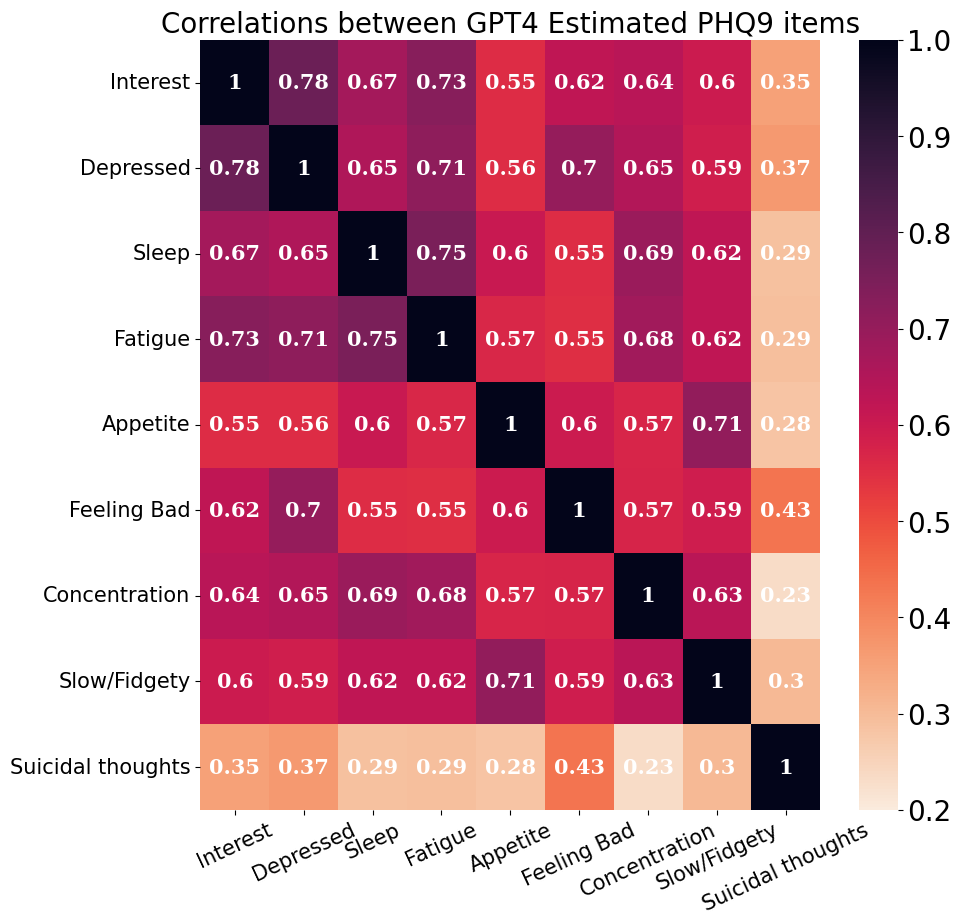

In [35]:
# Correlation in between all the items 
corr_df = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr().values
# Turn this into sns heatmap, with x axis label rotated 35 degrees, font size of the correlation values inside the heatmap as 20
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.20, vmax=1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            })
plt.title('Correlations between GPT4 Estimated PHQ9 items', fontsize=20)
tick_pos = range(9)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicidal thoughts']
# ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=25, fontsize=15)
ax.set_yticklabels(tick_labels, rotation=0, fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
# save figure
# plt.savefig('./figures/gpt4_item_corr.png', dpi=750, bbox_inches='tight')
plt.show()

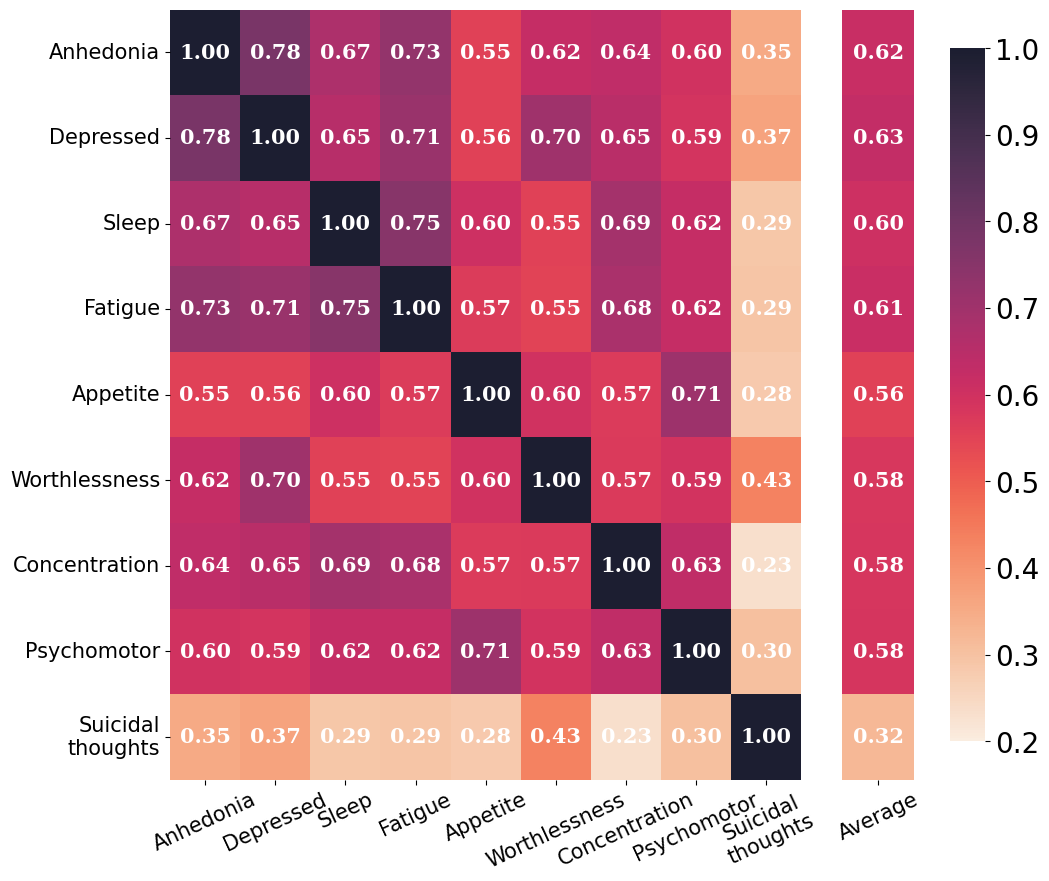

In [36]:
# Correlation in between all the items 
corr_df = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr().values
# Turn this into sns heatmap, with x axis label rotated 35 degrees, font size of the correlation values inside the heatmap as 20


f, (a0, a1) = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [3.5, 1], 'wspace': 0.1})


sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.20, vmax=1, alpha=0.9, fmt='.2f',  annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, ax=a0, cbar=False)
tick_pos = range(9)
tick_labels = ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal\nthoughts']
a0.set_xticklabels(tick_labels, rotation=25, fontsize=15)
a0.set_yticklabels(tick_labels, rotation=0, fontsize=15)

avgs = ((corr_df.sum(axis=1)-1.0)/8).reshape(-1, 1)
sns.heatmap(avgs, annot=True, cmap='rocket_r', vmin=0.20, vmax=1, alpha=0.9, fmt='.2f', ax=a1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'fraction': 0.4, 'shrink':0.9, 'pad': 0.2}, cbar=True)
a1.set_yticklabels([])
a1.tick_params(left=False)
a1.set_xticklabels(['Average'], rotation=25, fontsize=15)
cbar = a1.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# plt.savefig('./figures/gpt4_item_corr.png', dpi=750, bbox_inches='tight')
plt.show()
# save figure


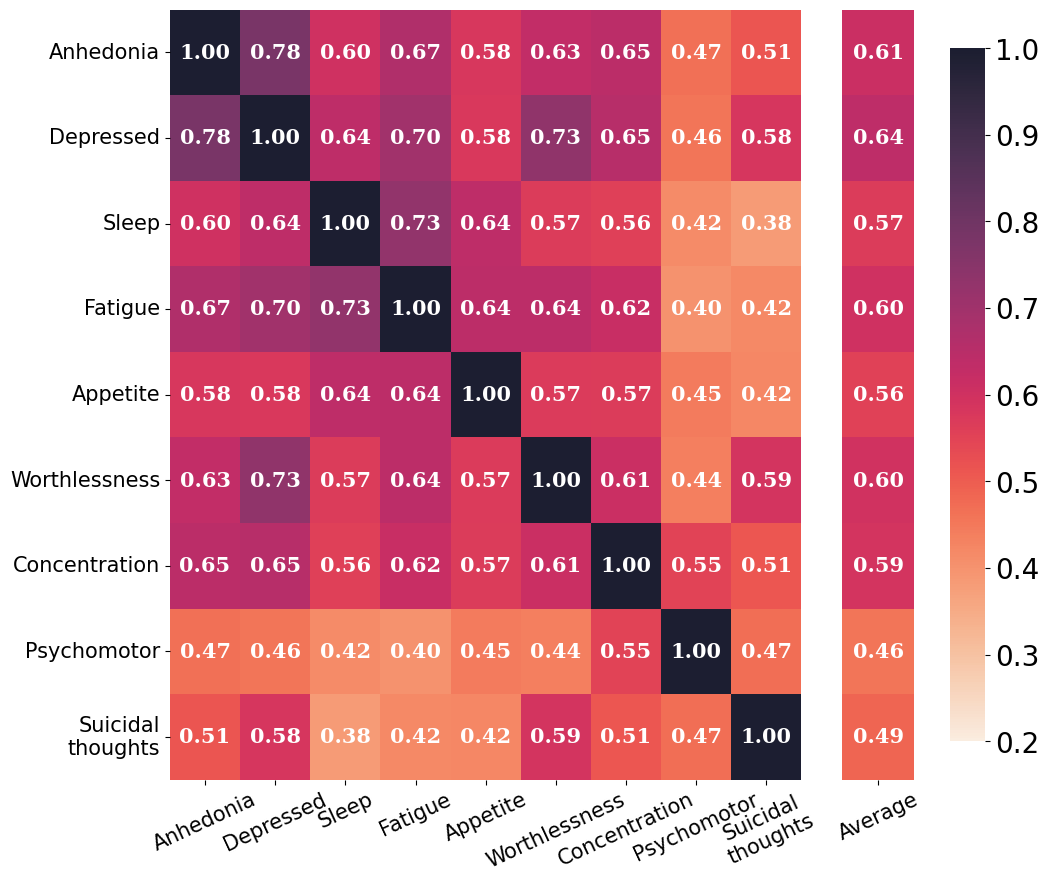

In [37]:
# Correlation in between all the items self reported  
corr_df = target_df[target_df.user_id.isin(parsed_response_df.user_id)][['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].rename(dict([(v, k) for k, v in PHQ_ITEM_COLUMN_MAPPING.items()])).corr().values

f, (a0, a1) = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [3.5, 1], 'wspace': 0.1})

sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.20, vmax=1, alpha=0.9, fmt='.2f', annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, ax=a0, cbar=False)
tick_pos = range(9)
tick_labels = ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal\nthoughts']
a0.set_xticklabels(tick_labels, rotation=25, fontsize=15)
a0.set_yticklabels(tick_labels, rotation=0, fontsize=15)

avgs = ((corr_df.sum(axis=1)-1.0)/8).reshape(-1, 1)
sns.heatmap(avgs, annot=True, cmap='rocket_r', vmin=0.20, vmax=1, alpha=0.9,fmt='.2f', ax=a1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'fraction': 0.4, 'shrink':0.9, 'pad': 0.2}, cbar=True)
a1.set_yticklabels([])
a1.tick_params(left=False)
a1.set_xticklabels(['Average'], rotation=25, fontsize=15)
cbar = a1.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# plt.savefig('./figures/selfreport_item_corr.png', dpi=750, bbox_inches='tight')
plt.show()

# save figure


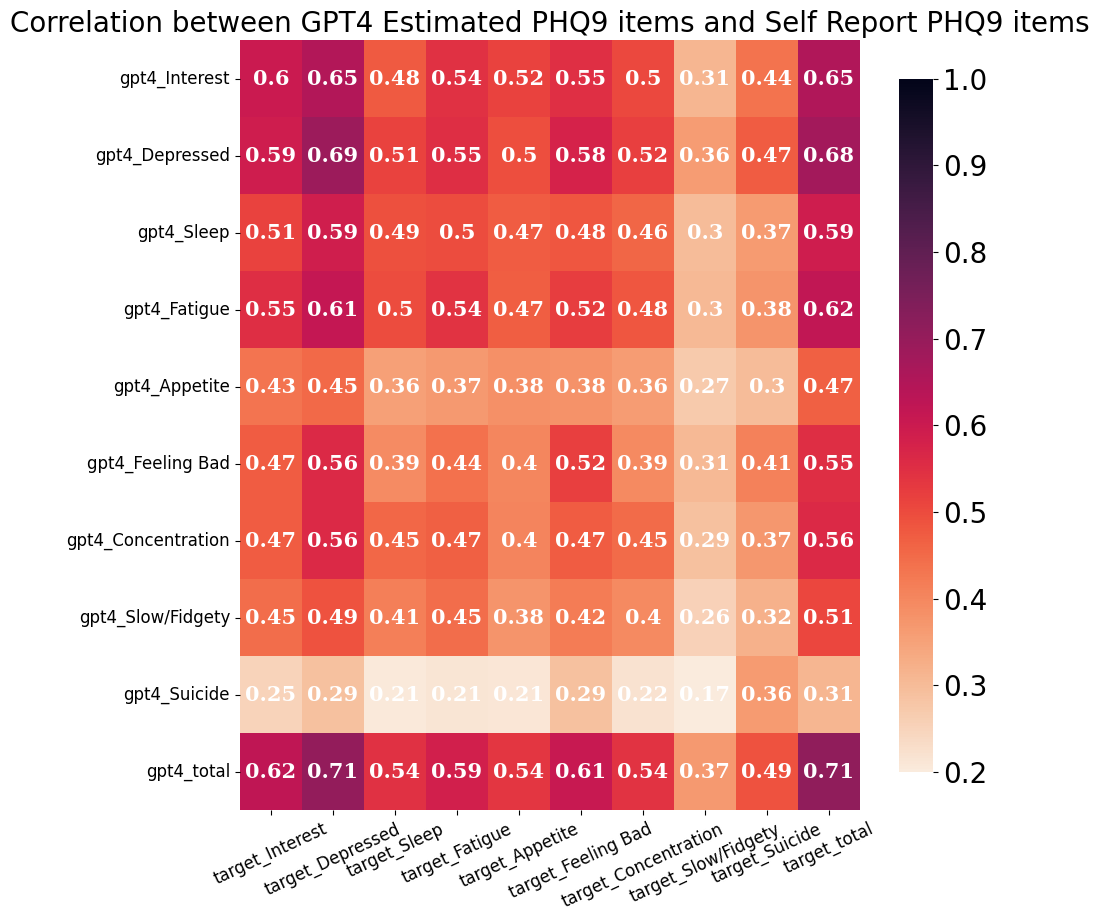

In [38]:

corr_df = np.zeros((10, 10))
x_y = pd.merge(parsed_response_df[['user_id']+['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]], target_df[['user_id']+['{}'.format(j) for j in PHQ_ITEM_COLUMN_MAPPING.values()]], on='user_id')
# Correlate the GPT4 estimated items with self reported items
x_y['score_total'] = x_y[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].sum(1)
x_y['target_total'] = x_y[['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].sum(1)

rows = list(PHQ_ITEM_COLUMN_MAP.values()) + ['total']
cols = list(PHQ_ITEM_COLUMN_MAPPING.values()) + ['target_total']

for i,col_i in enumerate(rows):
    x = x_y['score_{}'.format(col_i)]
    for j,col_j in enumerate(cols):
        y = x_y[col_j]
        corr_df[i][j] = pearsonr(x.values, y.values)[0]

plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.20, vmax=1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'shrink': 0.9})
# plt.title('Correlation between GPT4 Estimated PHQ9 items', fontsize=20)
tick_pos = range(10)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicide', 'total']
plt.title('Correlation between GPT4 Estimated PHQ9 items and Self Report PHQ9 items', fontsize=20)
# ax.set_xticks([i+0.15 for i in range(9)] + [9.75])
ax.set_yticklabels(['gpt4_{}'.format(i) for i in tick_labels], rotation=0, fontsize=12)
ax.set_xticklabels(['target_{}'.format(i) for i in tick_labels], rotation=25, fontsize=12)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
# savefig to ./data/gpt4_selfreport_item_corr.png


In [39]:
print(sns.color_palette("coolwarm").as_hex())

['#6788ee', '#9abbff', '#c9d7f0', '#edd1c2', '#f7a889', '#e26952']


In [40]:
sns.color_palette(['#5b82fc', '#9abbff', '#acb4c2', '#edd1c2', '#f7a889', '#f76c52'], as_cmap=True)

['#5b82fc', '#9abbff', '#acb4c2', '#edd1c2', '#f7a889', '#f76c52']

In [41]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as clr

# https://stackoverflow.com/questions/38147997/how-to-change-a-linearsegmentedcolormap-to-a-different-distribution-of-color
clrs = list(map(lambda x: (x[0]/8.0, x[1]), enumerate(['#5a77d1', '#6788ee', '#9abbff', '#c9d7f0', '#8c93a1', '#edd1c2', '#f7a889', '#e26952', '#c95a44'])))
clrs = list(map(lambda x: (x[0]/6.0, x[1]), enumerate(['#5a77d1', '#6788ee', '#9abbff', '#a9aaab', '#f7a889', '#e26952', '#c95a44'])))
# clrs = list(map(lambda x: (x[0]/7.0, x[1]), enumerate(['#5a77d1', '#9abbff', '#c9d7f0', '#aeb9cf', '#edd1c2', '#f7a889', '#e26952', '#c95a44'])))

custom_cmap = clr.LinearSegmentedColormap.from_list('custom coolwarm', clrs, N=256)

# cmap = {obsv_id:np.random.random() for obsv_id in range(9)}
# sm = ScalarMappable(norm=Normalize(vmin=min(list(cmap.values())), vmax=max(list(cmap.values()))), cmap=sns.cubehelix_palette(as_cmap=True))


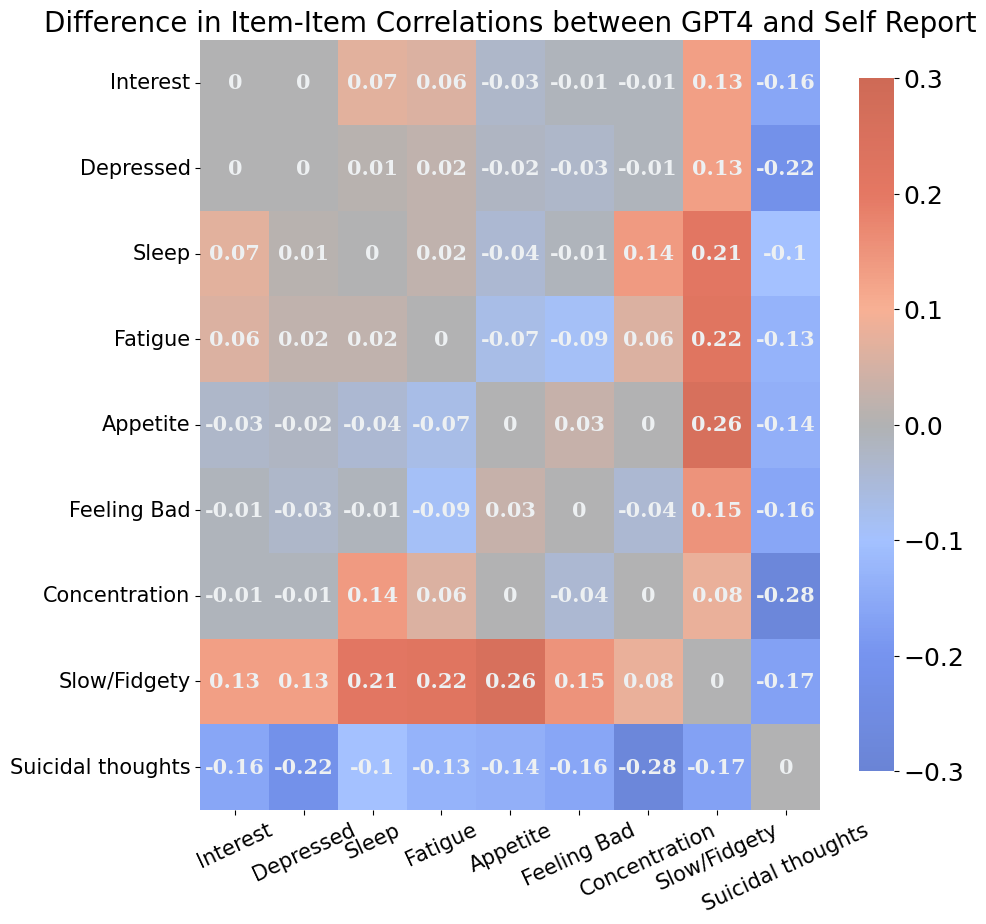

In [42]:
# Difference between GPT4 estimated items correlations and Self report items correlations

# gpt4_items_corr = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
gpt4_items_corr = x_y[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
selfreport_items_corr = x_y[['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].corr()

# selfreport_items_corr = target_df[target_df.user_id.isin(parsed_response_df.user_id)][['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].rename(dict([(v, k) for k, v in PHQ_ITEM_COLUMN_MAPPING.items()])).corr()

diff_corr = np.round(gpt4_items_corr.values - selfreport_items_corr.values, 2)

# Turn this into sns heatmap, with x axis label rotated 35 degrees
plt.figure(figsize=(10, 10))
ax = sns.heatmap(diff_corr, annot=True, cmap=custom_cmap, vmin=-0.3, vmax=0.3, alpha=0.90, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': '#edf0f2',
                'alpha': 1
            }, cbar_kws={'shrink': 0.9})
plt.title('Difference in Item-Item Correlations between GPT4 and Self Report', fontsize=20)
tick_pos = range(9)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicidal thoughts']
# ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=25, fontsize=15)
ax.set_yticklabels(tick_labels, rotation=0, fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=18)
plt.show()


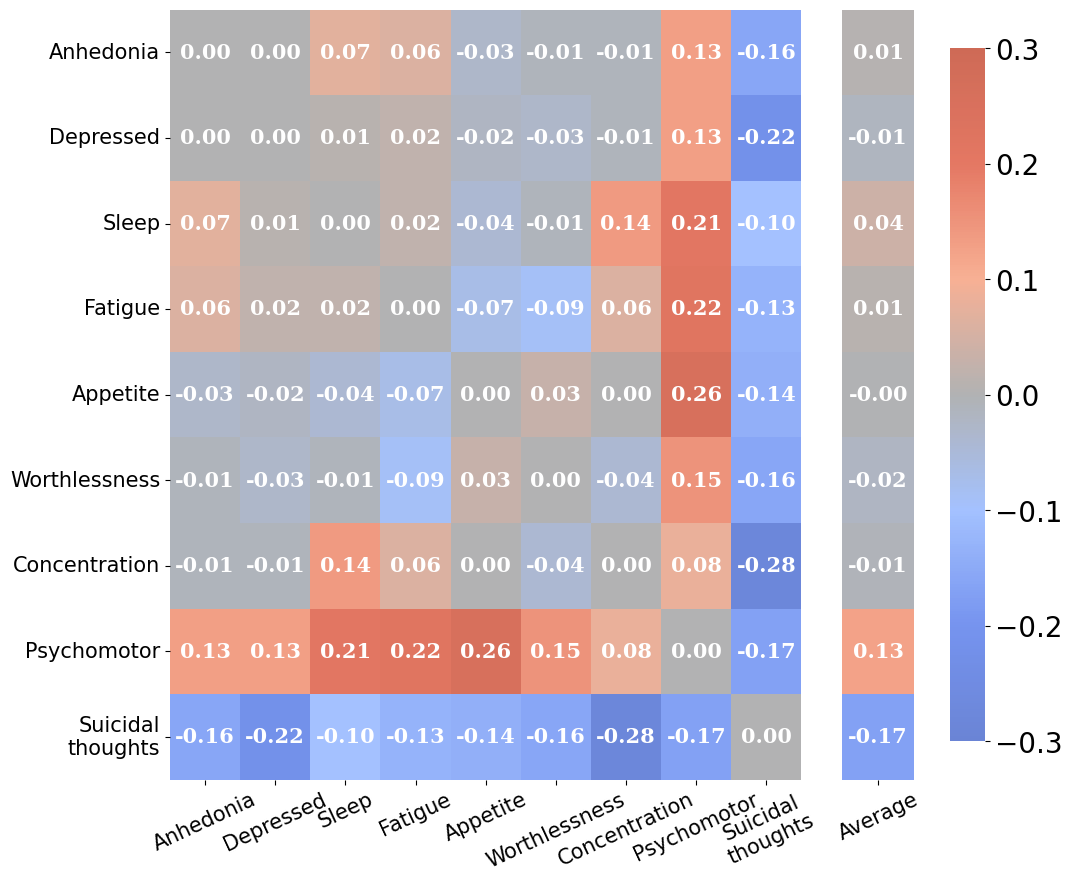

In [43]:
# Difference between GPT4 estimated items correlations and Self report items correlations

# gpt4_items_corr = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
gpt4_items_corr = x_y[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
selfreport_items_corr = x_y[['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].corr()

# selfreport_items_corr = target_df[target_df.user_id.isin(parsed_response_df.user_id)][['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].rename(dict([(v, k) for k, v in PHQ_ITEM_COLUMN_MAPPING.items()])).corr()

diff_corr = np.round(gpt4_items_corr.values - selfreport_items_corr.values, 2)

f, (a0, a1) = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [3.5, 1], 'wspace': 0.1})

sns.heatmap(diff_corr, annot=True,cmap=custom_cmap,vmin=-0.3, vmax=0.3, alpha=0.90, fmt='.2f', annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, ax=a0, cbar=False)
tick_pos = range(9)
tick_labels = ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal\nthoughts']
a0.set_xticklabels(tick_labels, rotation=25, fontsize=15)
a0.set_yticklabels(tick_labels, rotation=0, fontsize=15)

avgs = (diff_corr.mean(axis=1)*9/8.0).reshape(-1, 1)
sns.heatmap(avgs, annot=True, cmap=custom_cmap, vmin=-0.3, vmax=0.3, alpha=0.90, fmt='.2f', ax=a1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'fraction': 0.4, 'shrink':0.9, 'pad': 0.2}, cbar=True)
a1.set_yticklabels([])
a1.tick_params(left=False)
a1.set_xticklabels(['Average'], rotation=25, fontsize=15)
cbar = a1.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# plt.savefig('./figures/diff_gpt4_sr_item_corr.png', dpi=750, bbox_inches='tight')
plt.show()
# save figure

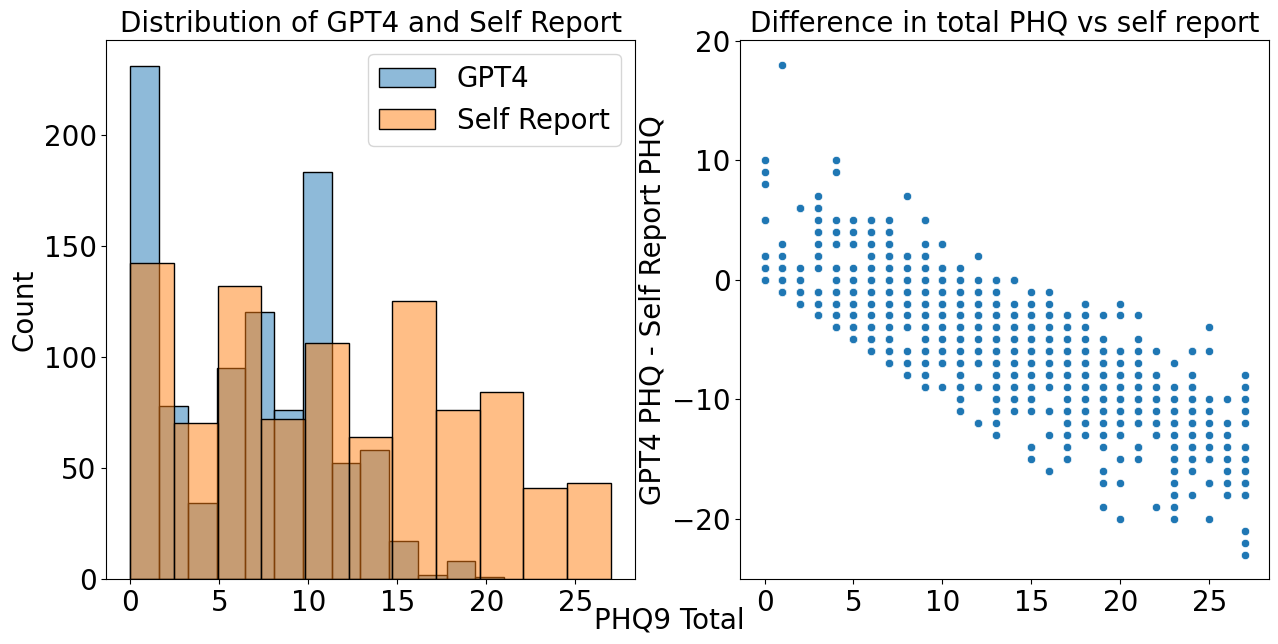

In [44]:
# Plot the Distribution of GPT4 total PHQ9 and self report PHQ9 total
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
x = parsed_response_df[score_columns].sum(1).values
y = parsed_response_df.target_value.values
sns.histplot(x, label='GPT4', alpha=0.5, ax=axs[0])
sns.histplot(y, label='Self Report', alpha=0.5, ax=axs[0])
axs[0].set_title('Distribution of GPT4 and Self Report', fontsize=20)
axs[0].legend(fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_ylabel('Count', fontsize=20)

# Plot of error in GPT4 and Self report PHQ9 total vs Self report PHQ9 total
y = (parsed_response_df[score_columns].sum(1) - parsed_response_df.target_value).values
x = parsed_response_df.target_value.values
sns.scatterplot(x=x, y=y, ax=axs[1])
axs[1].set_title('Difference in total PHQ vs self report', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
# set the x-axis label
axs[1].set_ylabel('GPT4 PHQ - Self Report PHQ', fontsize=20)

# Set common y label as PHQ9 total
fig.text(0.5, 0.04, 'PHQ9 Total', ha='center', fontsize=20)
plt.show()

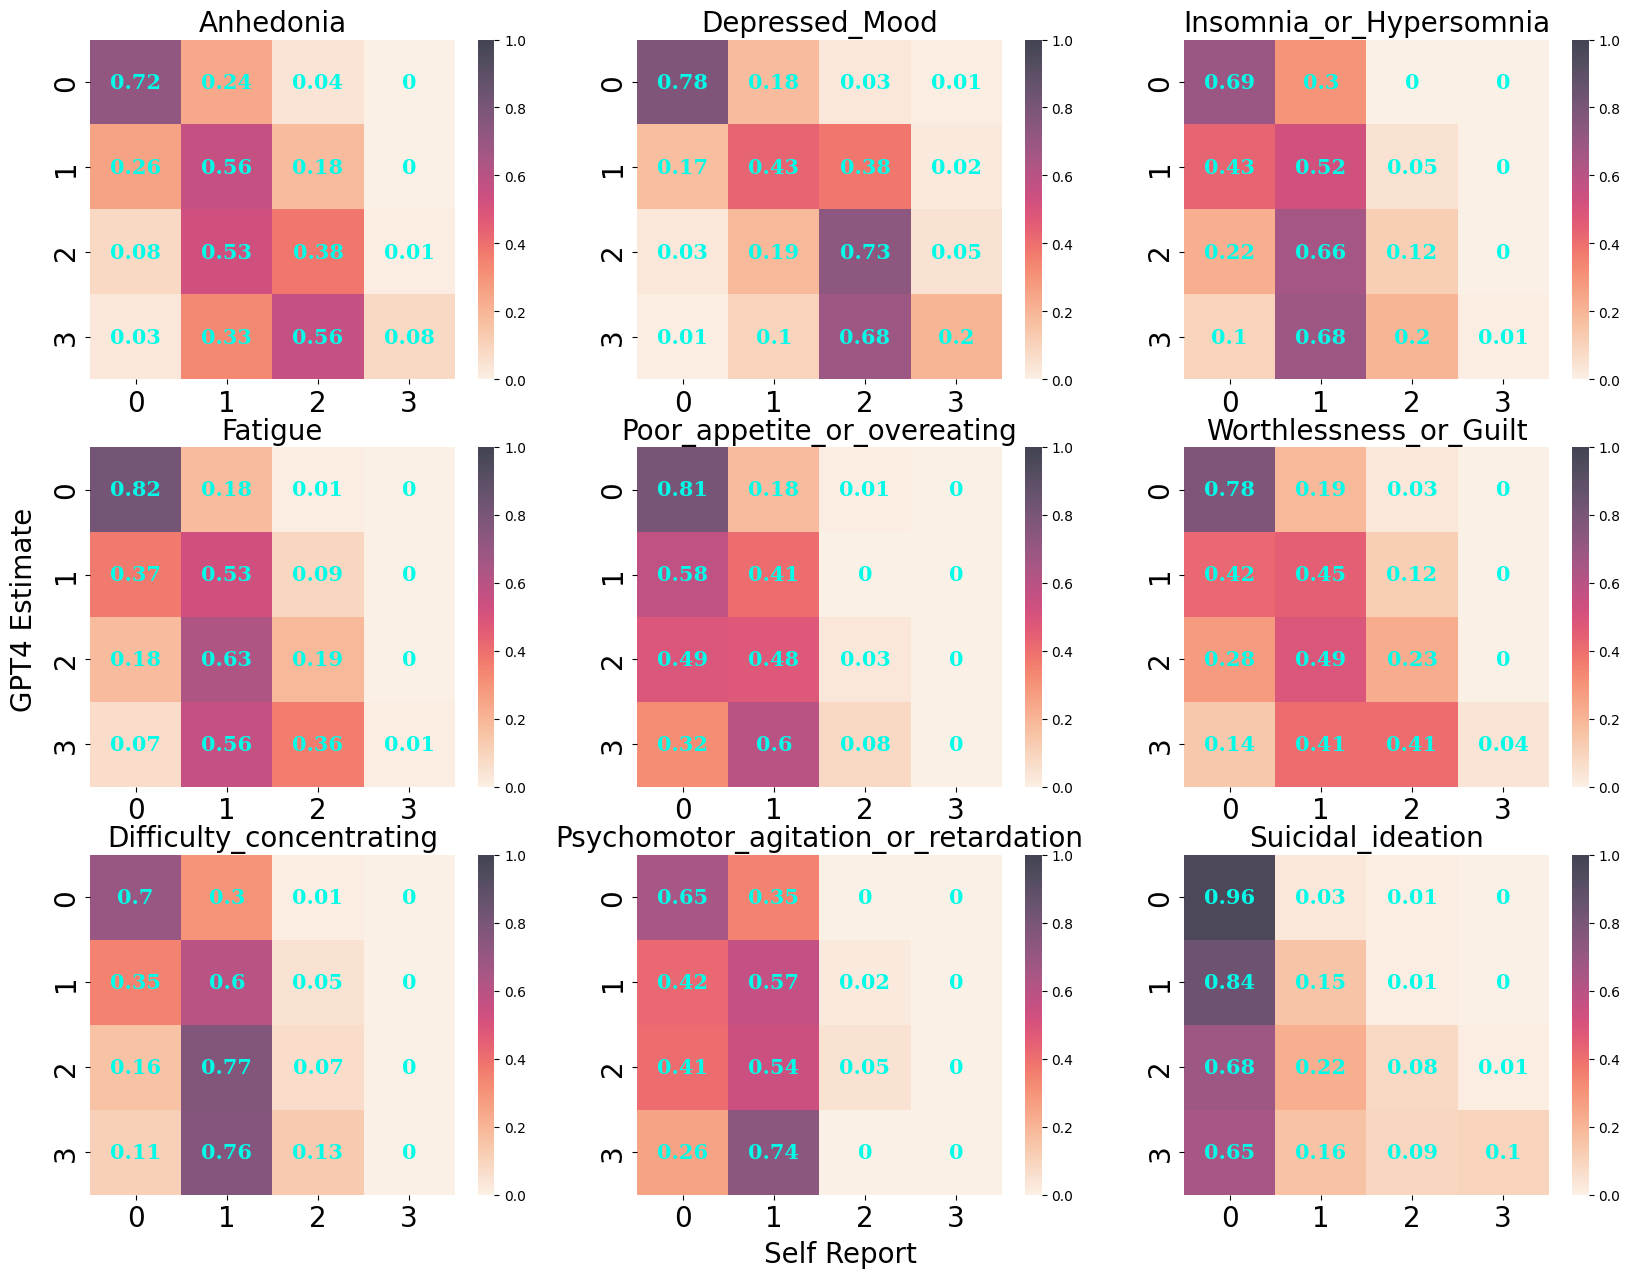

In [45]:
# Create a 3x3 grid of plots, with each plot showing scatter plot of error in GPT4 estimated score for each item and self report score for each item
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, ax in enumerate(axs.flatten()):
    y = x_y['score_{}'.format(list(PHQ_ITEM_COLUMN_MAP.values())[i])].values 
    x = x_y['{}'.format(list(PHQ_ITEM_COLUMN_MAPPING.values())[i])].values
    sns.heatmap((confusion_matrix(y_pred=y, y_true=x, normalize='true')).round(2), annot=True, cmap='rocket_r', ax=ax, vmin=-0.0, vmax=1, alpha=0.75, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': '#03fce8'
            })      
    # sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_title(list(PHQ_ITEM_COLUMN_MAP.values())[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    # ax.legend(fontsize=10)
# add common x axis and y axis label as self report and GPT4
fig.text(0.5, 0.065, 'Self Report', ha='center', fontsize=20)
fig.text(0.085, 0.5, 'GPT4 Estimate', va='center', rotation='vertical', fontsize=20)

# plt.savefig('./figures/gpt4_sr_item_dist.png', dpi=1000, bbox_inches='tight')
plt.show()


In [46]:
# Text legth vs depression score
word_counts = target_df[target_df.user_id.isin(parsed_response_df.user_id)].dep_text.apply(lambda x: len(x.split())) 
distinct_word_counts = target_df[target_df.user_id.isin(parsed_response_df.user_id)].dep_text.apply(lambda x: len(set(x.split())))
character_counts = target_df[target_df.user_id.isin(parsed_response_df.user_id)].dep_text.apply(lambda x: len(x) - len(x.replace(' ', '')))
dep_score = target_df[target_df.user_id.isin(parsed_response_df.user_id)].phq_score 
word_counts_pearsonr, p_val = pearsonr(word_counts, dep_score)
print ("Correlation between word counts and depression score: {} (p={})".format(round(word_counts_pearsonr, 3), round(p_val, 3)))
distinct_word_counts_pearsonr, p_val = pearsonr(distinct_word_counts, dep_score)
print ("Correlation between distinct word counts and depression score: {} (p={})".format(round(distinct_word_counts_pearsonr, 3), round(p_val, 3)))

Correlation between word counts and depression score: 0.136 (p=0.0)
Correlation between distinct word counts and depression score: 0.155 (p=0.0)


In [47]:
# Check if predictions are more accurate when the length is longer
temp_df = pd.merge(parsed_response_df, target_df[['user_id', 'dep_text']], on='user_id')
gpt4_error = temp_df['target_value'] - temp_df[score_columns].sum(1)
distinct_word_count = temp_df['dep_text'].apply(lambda x: len(set(x.split())))
word_count = temp_df['dep_text'].apply(lambda x: len(x.split()))

error_wc_pearsonr, p_val = pearsonr(gpt4_error, word_count)
print ("Correlation between GPT4 error and word count: {} (p={})".format(round(error_wc_pearsonr, 3), round(p_val, 3)))
abs_error_wc_pearsonr, p_val = pearsonr(np.abs(gpt4_error), word_count)
print ("Correlation between GPT4 abs error and word count: {} (p={})".format(round(abs_error_wc_pearsonr, 3), round(p_val, 3)))

error_dwc_pearsonr, p_val = pearsonr(gpt4_error, distinct_word_count)
print ("Correlation between GPT4 error and distinct word count: {} (p={})".format(round(error_dwc_pearsonr, 3), round(p_val, 3)))
abs_error_dwc_pearsonr, p_val = pearsonr(np.abs(gpt4_error), distinct_word_count)
print ("Correlation between GPT4 abs error and distinct word count: {} (p={})".format(round(abs_error_dwc_pearsonr, 3), round(p_val, 3)))


Correlation between GPT4 error and word count: -0.013 (p=0.693)
Correlation between GPT4 abs error and word count: -0.044 (p=0.178)
Correlation between GPT4 error and distinct word count: -0.006 (p=0.864)
Correlation between GPT4 abs error and distinct word count: -0.032 (p=0.319)


In [48]:
flesch_reading_ease = temp_df.dep_text.apply(lambda x: textstat.flesch_reading_ease(x))
flesch_kincaid_grade = temp_df.dep_text.apply(lambda x: textstat.flesch_kincaid_grade(x))
syllable_count = temp_df.dep_text.apply(lambda x: textstat.syllable_count(x))
lexicon_count = temp_df.dep_text.apply(lambda x: textstat.lexicon_count(x, removepunct=True))
poly_syllable_count = temp_df.dep_text.apply(lambda x: textstat.polysyllabcount(x))
mono_syllable_count = temp_df.dep_text.apply(lambda x: textstat.monosyllabcount(x))

# combine all the above with temp_df and correlate gpt4 prediction score, target_value and gpt's error with these metrics
temp_df['flesch_reading_ease'] = flesch_reading_ease
temp_df['flesch_kincaid_grade'] = flesch_kincaid_grade
temp_df['syllable_count'] = syllable_count
temp_df['lexicon_count'] = lexicon_count
temp_df['poly_syllable_count'] = poly_syllable_count
temp_df['mono_syllable_count'] = mono_syllable_count

# Correlate gpt4 prediction score, target_value and gpt's error with these metrics
gpt4_error = temp_df['target_value'] - temp_df[score_columns].sum(1)
gpt4_error_readability_corr = temp_df[['flesch_reading_ease', 'flesch_kincaid_grade', 'syllable_count', 'lexicon_count', 'poly_syllable_count', 'mono_syllable_count']].corrwith(gpt4_error)
gpt4_pred_readability_corr = temp_df[['flesch_reading_ease', 'flesch_kincaid_grade', 'syllable_count', 'lexicon_count', 'poly_syllable_count', 'mono_syllable_count']].corrwith(temp_df[score_columns].sum(1))
selfreport_readablilty_corr = temp_df[['flesch_reading_ease', 'flesch_kincaid_grade', 'syllable_count', 'lexicon_count', 'poly_syllable_count', 'mono_syllable_count']].corrwith(temp_df['target_value'])

print ('----------------------------------------------')
print ('Correlation between GPT4 error and readability metrics')
print ('----------------------------------------------')
# Format to 2 decimal places
print (gpt4_error_readability_corr.round(2))
print ('----------------------------------------------')
print ('Correlation between GPT4 prediction and readability metrics')
print ('----------------------------------------------')
# Format to 2 decimal places
print (gpt4_pred_readability_corr.round(2))
print ('----------------------------------------------')
print ('Correlation between Self report and readability metrics')
print ('----------------------------------------------')
# Format to 2 decimal places
print (selfreport_readablilty_corr.round(2))
print ('----------------------------------------------')

----------------------------------------------
Correlation between GPT4 error and readability metrics
----------------------------------------------
flesch_reading_ease     0.03
flesch_kincaid_grade    0.01
syllable_count         -0.02
lexicon_count          -0.01
poly_syllable_count    -0.07
mono_syllable_count    -0.00
dtype: float64
----------------------------------------------
Correlation between GPT4 prediction and readability metrics
----------------------------------------------
flesch_reading_ease    -0.05
flesch_kincaid_grade    0.04
syllable_count          0.23
lexicon_count           0.23
poly_syllable_count     0.18
mono_syllable_count     0.23
dtype: float64
----------------------------------------------
Correlation between Self report and readability metrics
----------------------------------------------
flesch_reading_ease    -0.01
flesch_kincaid_grade    0.04
syllable_count          0.13
lexicon_count           0.14
poly_syllable_count     0.07
mono_syllable_count     

### Explicit and Inferred Items correlations 

In [49]:
# Calculate the % isInferred=1 for each item
perc_isinferred = {}
for item in PHQ_ITEM_COLUMN_MAP.values():
    perc_item_isinferred = parsed_response_df[parsed_response_df['isInferred_{}'.format(item)]==1].shape[0] / parsed_response_df.shape[0]
    perc_isinferred[item] = round(perc_item_isinferred*100, 2)

perc_isinferred = sorted(perc_isinferred.items(), key=lambda x: -x[1])
for item, perc in perc_isinferred:
    print ('IsInferred % for Item {}: {}'.format(item, perc))

IsInferred % for Item Psychomotor_agitation_or_retardation: 96.65
IsInferred % for Item Poor_appetite_or_overeating: 94.97
IsInferred % for Item Suicidal_ideation: 94.45
IsInferred % for Item Difficulty_concentrating: 90.58
IsInferred % for Item Insomnia_or_Hypersomnia: 88.69
IsInferred % for Item Worthlessness_or_Guilt: 75.81
IsInferred % for Item Fatigue: 74.87
IsInferred % for Item Anhedonia: 46.28
IsInferred % for Item Depressed_Mood: 3.56


In [50]:
# Calculate the correlation for each item when it was inferred vs when it was not inferred
correlations = {0: {}, 1: {}}
for item in PHQ_ITEM_COLUMN_MAP.values():
    for isInferred in [0, 1]:
        gpt4_item_pred = parsed_response_df[parsed_response_df['isInferred_{}'.format(item)]==isInferred][['user_id', 'score_{}'.format(item)]]
        target_item_pred = target_df[['user_id', 'target_{}'.format(item)]]
        items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
        corr, p_val = pearsonr(items_df[['target_{}'.format(item)]].values.reshape(-1, ), items_df[['score_{}'.format(item)]].values.reshape(-1, ))
        correlations[isInferred][item] = (round(corr, 3), items_df.shape[0])
    # print ('Item correlation {}: {}/{}'.format(i, round(corr, 3), round(p_val, 3)))

# correlations = sorted(correlations.items(), key=lambda x: -x[1])
correlations[0] = sorted(correlations[0].items(), key=lambda x: -x[1][0])
correlations[1] = sorted(correlations[1].items(), key=lambda x: -x[1][0])
for isInferred, corr in correlations.items():
    for item, (corr, n) in corr:
        if isInferred == 0:
            print ('Correlation for Item {} when it was not inferred: {} (n={})'.format(item, corr, n))
        else:
            print ('Correlation for Item {} when it was inferred: {} (n={})'.format(item, corr, n))

Correlation for Item Suicidal_ideation when it was not inferred: 0.746 (n=53)
Correlation for Item Anhedonia when it was not inferred: 0.709 (n=513)
Correlation for Item Depressed_Mood when it was not inferred: 0.699 (n=921)
Correlation for Item Fatigue when it was not inferred: 0.581 (n=240)
Correlation for Item Worthlessness_or_Guilt when it was not inferred: 0.574 (n=231)
Correlation for Item Insomnia_or_Hypersomnia when it was not inferred: 0.517 (n=108)
Correlation for Item Difficulty_concentrating when it was not inferred: 0.503 (n=90)
Correlation for Item Poor_appetite_or_overeating when it was not inferred: 0.475 (n=48)
Correlation for Item Psychomotor_agitation_or_retardation when it was not inferred: 0.33 (n=32)
Correlation for Item Fatigue when it was inferred: 0.513 (n=715)
Correlation for Item Worthlessness_or_Guilt when it was inferred: 0.451 (n=724)
Correlation for Item Difficulty_concentrating when it was inferred: 0.449 (n=865)
Correlation for Item Depressed_Mood when 

In [66]:
# Run ttest between the implicit and explicit item scores from GPT4
from scipy.stats import ttest_ind
ttest_results = {}
for item in PHQ_ITEM_COLUMN_MAP.values():
    inferred_rows = parsed_response_df['isInferred_{}'.format(item)] == 1
    inferred_scores = parsed_response_df[inferred_rows]['score_{}'.format(item)]
    explicit_scores = parsed_response_df[~inferred_rows]['score_{}'.format(item)]
    ttest_results[item] = ttest_ind(inferred_scores, explicit_scores, equal_var=False)

pprint (ttest_results)

{'Anhedonia': Ttest_indResult(statistic=-2.1395568218557575, pvalue=0.03266811523893123),
 'Depressed_Mood': Ttest_indResult(statistic=-2.1544984326192496, pvalue=0.037902121272265166),
 'Difficulty_concentrating': Ttest_indResult(statistic=-8.92858791621058, pvalue=2.1433034607509605e-14),
 'Fatigue': Ttest_indResult(statistic=-16.395940771057063, pvalue=2.1997620221080583e-45),
 'Insomnia_or_Hypersomnia': Ttest_indResult(statistic=-18.429450899170742, pvalue=8.641931948670895e-38),
 'Poor_appetite_or_overeating': Ttest_indResult(statistic=-10.544620932690133, pvalue=2.853168789361492e-14),
 'Psychomotor_agitation_or_retardation': Ttest_indResult(statistic=-10.046265470593296, pvalue=1.143703389352987e-11),
 'Suicidal_ideation': Ttest_indResult(statistic=-11.670316425674617, pvalue=3.283350593524426e-16),
 'Worthlessness_or_Guilt': Ttest_indResult(statistic=-20.93486934052852, pvalue=8.824730855732522e-63)}


In [57]:
# Perform t test between explicit and implicit instances for each item to determine if correlations are significantly different
NUM_ITERS = 1000
item_corrs_for_ttest = {item: {0: [], 1: []} for item in PHQ_ITEM_COLUMN_MAP.values()}
for iter in range(NUM_ITERS):
    idxs = np.random.choice(len(parsed_response_df), size=len(parsed_response_df), replace=True)
    for item in PHQ_ITEM_COLUMN_MAP.values():
        # retrieve the idxs from parsed_response_df
        iter_gpt4_item_pred = parsed_response_df.iloc[idxs]
        iter_target_df = target_df[target_df.user_id.isin(iter_gpt4_item_pred.user_id)]
        for isInferred in [0, 1]:
            gpt4_item_pred = iter_gpt4_item_pred[iter_gpt4_item_pred['isInferred_{}'.format(item)]==isInferred][['user_id', 'score_{}'.format(item)]]
            target_item_pred = iter_target_df[['user_id', 'target_{}'.format(item)]]
            items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
            corr, p_val = pearsonr(items_df[['target_{}'.format(item)]].values.reshape(-1, ), items_df[['score_{}'.format(item)]].values.reshape(-1, ))
            item_corrs_for_ttest[item][isInferred].append(corr)

/chronos_data/conda_envs/gpt3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [64]:
# Run t-test between explicit and implicit instances for each item
ttest_results = {}
for item, corrs in item_corrs_for_ttest.items():
    x = np.array(corrs[0])
    y = np.array(corrs[1])
    x, y = x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)]
    ttest_results[item] = ttest_ind(x, y, equal_var=False)

pprint (ttest_results)

{'Anhedonia': Ttest_indResult(statistic=186.11568692974177, pvalue=0.0),
 'Depressed_Mood': Ttest_indResult(statistic=55.33154800049885, pvalue=7.085604460713e-311),
 'Difficulty_concentrating': Ttest_indResult(statistic=21.403602519201733, pvalue=4.82371282496172e-87),
 'Fatigue': Ttest_indResult(statistic=39.738581997056784, pvalue=1.888917052302798e-242),
 'Insomnia_or_Hypersomnia': Ttest_indResult(statistic=23.011462279391637, pvalue=4.835496051858275e-97),
 'Poor_appetite_or_overeating': Ttest_indResult(statistic=25.845135291616188, pvalue=3.2173361687584767e-115),
 'Psychomotor_agitation_or_retardation': Ttest_indResult(statistic=17.195975507988237, pvalue=1.0305401942874638e-58),
 'Suicidal_ideation': Ttest_indResult(statistic=207.5018885679066, pvalue=0.0),
 'Worthlessness_or_Guilt': Ttest_indResult(statistic=68.4876937516195, pvalue=0.0)}


In [56]:
### TODO: Correlate language of reason with the assigned score for the items that were inferred
exp_imp_df = pd.merge(pd.DataFrame(map(lambda x: (x[0], x[1][0], x[1][1]), correlations[1]), columns=['item', 'correlation_inferred', 'n_inferred']), pd.DataFrame(map(lambda x: (x[0], x[1][0], x[1][1]), correlations[0]), columns=['item', 'correlation_explicit', 'n_explicit']), on='item')
exp_imp_df

,item,correlation_inferred,n_inferred,correlation_explicit,n_explicit
0,Fatigue,0.513,715,0.581,240
1,Worthlessness_or_Guilt,0.451,724,0.574,231
2,Difficulty_concentrating,0.449,865,0.503,90
3,Depressed_Mood,0.439,34,0.699,921
4,Insomnia_or_Hypersomnia,0.435,847,0.517,108
5,Anhedonia,0.428,442,0.709,513
6,Poor_appetite_or_overeating,0.335,907,0.475,48
7,Psychomotor_agitation_or_retardation,0.244,923,0.330,32
8,Suicidal_ideation,0.207,902,0.746,53


In [57]:
exp_imp_df.sort_values('correlation_explicit', ascending=False)


,item,correlation_inferred,n_inferred,correlation_explicit,n_explicit
8,Suicidal_ideation,0.207,902,0.746,53
5,Anhedonia,0.428,442,0.709,513
3,Depressed_Mood,0.439,34,0.699,921
0,Fatigue,0.513,715,0.581,240
1,Worthlessness_or_Guilt,0.451,724,0.574,231
4,Insomnia_or_Hypersomnia,0.435,847,0.517,108
2,Difficulty_concentrating,0.449,865,0.503,90
6,Poor_appetite_or_overeating,0.335,907,0.475,48
7,Psychomotor_agitation_or_retardation,0.244,923,0.330,32


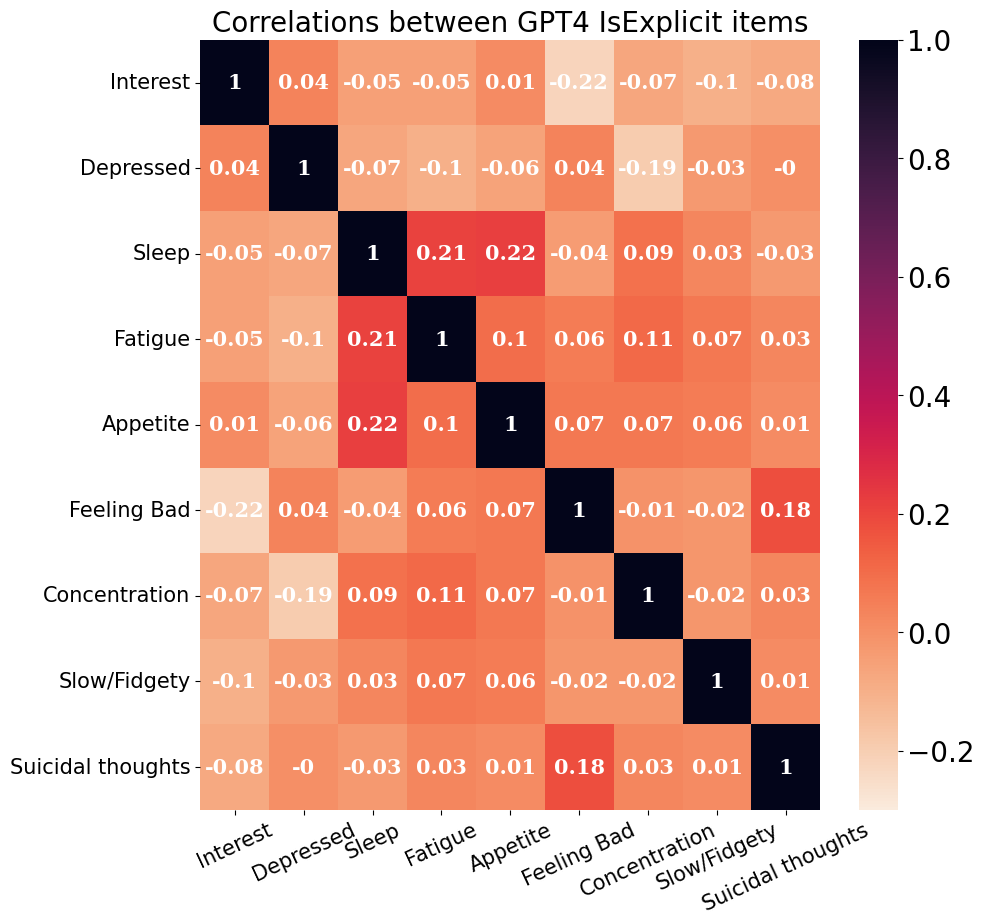

In [73]:
# Draw a pearson correlation plot of all the isInferred_{item} columns

isInferred_df = parsed_response_df[['isInferred_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]]
# Flip 0s and 1s 
isInferred_df = 1 - isInferred_df
isInferred_corr = isInferred_df.corr().round(2)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(isInferred_corr, annot=True, cmap='rocket_r', vmin=-0.3, vmax=1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            })
plt.title('Correlations between GPT4 IsExplicit items', fontsize=20)
tick_pos = range(9)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicidal thoughts']
# ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=25, fontsize=15)
ax.set_yticklabels(tick_labels, rotation=0, fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.show()


## Reasons 

In [76]:
x = parsed_response_df
x.columns

Index(['user_id', 'target_value', 'score_Anhedonia', 'reason_Anhedonia',
       'isInferred_Anhedonia', 'score_Depressed_Mood', 'reason_Depressed_Mood',
       'isInferred_Depressed_Mood', 'score_Insomnia_or_Hypersomnia',
       'reason_Insomnia_or_Hypersomnia', 'isInferred_Insomnia_or_Hypersomnia',
       'score_Fatigue', 'reason_Fatigue', 'isInferred_Fatigue',
       'score_Poor_appetite_or_overeating',
       'reason_Poor_appetite_or_overeating',
       'isInferred_Poor_appetite_or_overeating',
       'score_Worthlessness_or_Guilt', 'reason_Worthlessness_or_Guilt',
       'isInferred_Worthlessness_or_Guilt', 'score_Difficulty_concentrating',
       'reason_Difficulty_concentrating',
       'isInferred_Difficulty_concentrating',
       'score_Psychomotor_agitation_or_retardation',
       'reason_Psychomotor_agitation_or_retardation',
       'isInferred_Psychomotor_agitation_or_retardation',
       'score_Suicidal_ideation', 'reason_Suicidal_ideation',
       'isInferred_Suicidal_idea

In [81]:
gpt4_spans_cols = ['reason_'+col for col in ITEMS_UNDERSCORED.values()]
gpt4_inferred_cols = ['isInferred_'+col for col in ITEMS_UNDERSCORED.values()]
print (gpt4_spans_cols,'\n',gpt4_inferred_cols)

['reason_Anhedonia', 'reason_Depressed_Mood', 'reason_Insomnia_or_Hypersomnia', 'reason_Fatigue', 'reason_Poor_appetite_or_overeating', 'reason_Worthlessness_or_Guilt', 'reason_Difficulty_concentrating', 'reason_Psychomotor_agitation_or_retardation', 'reason_Suicidal_ideation'] 
 ['isInferred_Anhedonia', 'isInferred_Depressed_Mood', 'isInferred_Insomnia_or_Hypersomnia', 'isInferred_Fatigue', 'isInferred_Poor_appetite_or_overeating', 'isInferred_Worthlessness_or_Guilt', 'isInferred_Difficulty_concentrating', 'isInferred_Psychomotor_agitation_or_retardation', 'isInferred_Suicidal_ideation']


In [111]:
gpt4_spans_df = parsed_response_df[['user_id']+gpt4_spans_cols+gpt4_inferred_cols]
gpt4_spans_df = gpt4_spans_df.rename(columns={'reason_Depressed_Mood': 'reason_Depressed_mood', 'isInferred_Depressed_Mood': 'isInferred_Depressed_mood'})
gpt4_spans_df.head()

,user_id,reason_Anhedonia,reason_Depressed_mood,reason_Insomnia_or_Hypersomnia,reason_Fatigue,reason_Poor_appetite_or_overeating,reason_Worthlessness_or_Guilt,reason_Difficulty_concentrating,reason_Psychomotor_agitation_or_retardation,reason_Suicidal_ideation,isInferred_Anhedonia,isInferred_Depressed_mood,isInferred_Insomnia_or_Hypersomnia,isInferred_Fatigue,isInferred_Poor_appetite_or_overeating,isInferred_Worthlessness_or_Guilt,isInferred_Difficulty_concentrating,isInferred_Psychomotor_agitation_or_retardation,isInferred_Suicidal_ideation
0,1,'I have been interested in things as much as I...,"'Over the past two weeks, I have not been depr...",'my sleep has been pretty good.',No evidence of fatigue mentioned.,No evidence of poor appetite or overeating men...,No evidence of feelings of worthlessness or gu...,No evidence of difficulty concentrating mentio...,No evidence of psychomotor agitation or retard...,No evidence of suicidal ideation mentioned.,0,0,0,1,1,1,1,1,1
1,2,'I do find it hard to get pleasure out of things','I don't think I have felt depressed',No explicit mention; estimated based on availa...,No explicit mention; estimated based on availa...,No explicit mention; estimated based on availa...,'joylesssness - something my former husband al...,No explicit mention; estimated based on availa...,No explicit mention; estimated based on availa...,No explicit mention; estimated based on availa...,0,0,1,1,1,1,1,1,1
2,3,"No explicit mention, but depression often redu...",'I have been depressed',"No explicit mention, but stress about job loss...","No explicit mention, but depression is commonl...","No explicit mention, but stress and depression...",'doubtful whether I will find another one at m...,"No explicit mention, but worry and depression ...","No explicit mention, but depression can manife...",No explicit mention of suicidal thoughts or be...,1,0,1,1,1,0,1,1,1
3,4,'not being able to go out made it worse','feeling depressed',"No explicit mention, but depression often affe...","No explicit mention, but feeling depressed can...","No explicit mention, but depression can affect...","No explicit mention, but feeling depressed may...","No explicit mention, but depression can impair...","No explicit mention, but feeling worse could i...",No explicit mention of suicidal thoughts or be...,0,0,1,1,1,1,1,1,1
4,5,'no money to get out and see friends','everything is getting on top of me at the mom...,'just work and sleep','just work and sleep',Estimated based on the overall depressive mood...,'i don't like to ask to much as i feel i need ...,Estimated based on the reported overwhelmed state,Estimated based on the lack of energy and feel...,"No evidence in text, estimated as absent",0,0,0,0,1,0,1,1,1


### Veerle and GPT4

In [112]:
veerle_annotation = pd.read_csv('/home/avirinchipur/research/llm_reasoning_psych/data/Item_level_scores_Veerle.csv')
veerle_annotation.head()

,row_id,user_id,text,Anhedonia,Depressed mood,Insomnia or Hypersomnia,Fatigue,Poor appetite or overeating,Worthlessness or Guilt,Difficulty concentrating,...,Suicidal ideation,spans Anhedonia,spans Depressed mood,spans Difficulty concentrating,spans Fatigue,spans Insomnia or Hypersomnia,spans Poor appetite or overeating,spans Psychomotor agitation or retardation,spans Suicidal ideation,spans Worthlessness or Guilt
0,1,45,My depression is something I've learnt to live...,2,2,2,2,1.0,2,2,...,1,NaN,My depression is something I've learnt to live...,It brings out my anxiety,NaN,NaN,NaN,NaN,NaN,I feel like I'm the only one who feels this wa...
1,2,49,It’s becoming really stressful at the moment o...,1,1,2,2,1.0,1,2,...,0,NaN,NaN,It’s becoming really stressful at the moment\n...,NaN,NaN,NaN,NaN,NaN,as a mother of two I think about this
2,3,70,Yes I am regularly depressed and end up drinki...,2,2,2,2,1.0,2,2,...,1,but then there is absolutely nothing to do for...,Yes I am regularly depressed\nmaking the probl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,71,Over the last two weeks my mood has been posit...,0,1,0,0,0.0,0,0,...,0,I am able to make future plans with excitement,my mood has been positive\nI have not felt as ...,NaN,NaN,NaN,NaN,NaN,NaN,I have been able to reflect upon my life posit...
4,5,72,I'd been a little depressed off and on. Mainly...,0,1,1,1,1.0,1,1,...,0,I've been stuck at home for the most part\nesp...,I'd been a little depressed off and on\nI've b...,NaN,NaN,NaN,NaN,NaN,NaN,I feel as if I'm getting older and my looks ar...


In [113]:
annotation_col_dict = {'Anhedonia': 'PHQ.SQ01.', 'Depressed mood': 'PHQ.SQ02.', 'Insomnia or Hypersomnia': 'PHQ.SQ03.', 'Fatigue': 'PHQ.SQ04.', 'Poor appetite or overeating': 'PHQ.SQ05.', 
                       'Worthlessness or Guilt': 'PHQ.SQ06.', 'Difficulty concentrating': 'PHQ.SQ07.', 'Psychomotor agitation or retardation': 'PHQ.SQ08.', 'Suicidal ideation': 'PHQ.SQ09.'}
spans_cols = ['spans '+col for col in annotation_col_dict.keys()]

In [114]:
veerle_annotation_spans = veerle_annotation[['row_id', 'user_id', 'text']+spans_cols]
veerle_annotation_spans.head()

,row_id,user_id,text,spans Anhedonia,spans Depressed mood,spans Insomnia or Hypersomnia,spans Fatigue,spans Poor appetite or overeating,spans Worthlessness or Guilt,spans Difficulty concentrating,spans Psychomotor agitation or retardation,spans Suicidal ideation
0,1,45,My depression is something I've learnt to live...,NaN,My depression is something I've learnt to live...,NaN,NaN,NaN,I feel like I'm the only one who feels this wa...,It brings out my anxiety,NaN,NaN
1,2,49,It’s becoming really stressful at the moment o...,NaN,NaN,NaN,NaN,NaN,as a mother of two I think about this,It’s becoming really stressful at the moment\n...,NaN,NaN
2,3,70,Yes I am regularly depressed and end up drinki...,but then there is absolutely nothing to do for...,Yes I am regularly depressed\nmaking the probl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,71,Over the last two weeks my mood has been posit...,I am able to make future plans with excitement,my mood has been positive\nI have not felt as ...,NaN,NaN,NaN,I have been able to reflect upon my life posit...,NaN,NaN,NaN
4,5,72,I'd been a little depressed off and on. Mainly...,I've been stuck at home for the most part\nesp...,I'd been a little depressed off and on\nI've b...,NaN,NaN,NaN,I feel as if I'm getting older and my looks ar...,NaN,NaN,NaN


In [115]:
veerle_annotation_spans = veerle_annotation_spans.fillna('')
veerle_annotation_spans.head()

,row_id,user_id,text,spans Anhedonia,spans Depressed mood,spans Insomnia or Hypersomnia,spans Fatigue,spans Poor appetite or overeating,spans Worthlessness or Guilt,spans Difficulty concentrating,spans Psychomotor agitation or retardation,spans Suicidal ideation
0,1,45,My depression is something I've learnt to live...,,My depression is something I've learnt to live...,,,,I feel like I'm the only one who feels this wa...,It brings out my anxiety,,
1,2,49,It’s becoming really stressful at the moment o...,,,,,,as a mother of two I think about this,It’s becoming really stressful at the moment\n...,,
2,3,70,Yes I am regularly depressed and end up drinki...,but then there is absolutely nothing to do for...,Yes I am regularly depressed\nmaking the probl...,,,,,,,
3,4,71,Over the last two weeks my mood has been posit...,I am able to make future plans with excitement,my mood has been positive\nI have not felt as ...,,,,I have been able to reflect upon my life posit...,,,
4,5,72,I'd been a little depressed off and on. Mainly...,I've been stuck at home for the most part\nesp...,I'd been a little depressed off and on\nI've b...,,,,I feel as if I'm getting older and my looks ar...,,,


In [116]:
# Note: prolly a good diea to remove the \n if using ROUGE metric
print (veerle_annotation_spans['spans Depressed mood'].iloc[2], '\n', veerle_annotation_spans['text'].iloc[2])

Yes I am regularly depressed
making the problem worse
I am ok to around lunchtime 
 Yes I am regularly depressed and end up drinking too much, making the problem worse. I am ok to around lunchtime, but then there is absolutely nothing to do for the rest of the day, but drink or watch T.V.


In [145]:
span_match_rouge_veerle = {}
rouge = Rouge()
for col in spans_cols:
    # Get the span and user_id col from annotator
    temp_veerle_spans = veerle_annotation_spans[['user_id', col]]
    temp_veerle_spans[col] = temp_veerle_spans[col].apply(lambda x: x.replace('\n', ' '))
    # Get the user_id, span and isInferred col from GPT4
    temp_gpt_spans = gpt4_spans_df[['user_id', col.replace('spans', 'reason').replace(' ', '_'), 'isInferred'+col.replace('spans', '').replace(' ', '_')]]
    # merge these two based on user_id 
    temp_spans = pd.merge(temp_veerle_spans, temp_gpt_spans, on='user_id')
    # Turn reason_col into '' when isInferred_col is 0
    temp_spans.loc[temp_spans['isInferred'+col.replace('spans', '').replace(' ', '_')]==1, col.replace('spans', 'reason').replace(' ', '_')] = ''
    # Only filter to rows where spans col is not empty
    temp_spans = temp_spans[temp_spans[col].str.strip().str.len() > 0]
    # Fill the empty rows of reason col "SPANLESS"  
    temp_spans.loc[temp_spans[col.replace('spans', 'reason').replace(' ', '_')]=='', col.replace('spans', 'reason').replace(' ', '_')] = 'SPANLESS'
    rouge_score = rouge.get_scores(temp_spans[col], temp_spans[col.replace('spans', 'reason').replace(' ', '_')], avg=True, ignore_empty=False)
    span_match_rouge_veerle[col.replace('spans', '')] = rouge_score['rouge-1']['f']
    print ('{}: {}'.format(col.replace('spans', ''), len(temp_spans)))
    
    

 Anhedonia: 121
 Depressed mood: 204
 Insomnia or Hypersomnia: 30
 Fatigue: 31
 Poor appetite or overeating: 14
 Worthlessness or Guilt: 83
 Difficulty concentrating: 36
 Psychomotor agitation or retardation: 3
 Suicidal ideation: 72


/home/avirinchipur/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [146]:
veerle_rouge_scores = pd.DataFrame(span_match_rouge_veerle, index=['rouge-l', 'rouge-1', 'rouge-2']).T.sort_values('rouge-l', ascending=False)
# all floating points to three decimal places
veerle_rouge_scores = veerle_rouge_scores.round(3)
veerle_rouge_scores

,rouge-l,rouge-1,rouge-2
Depressed mood,0.469,0.469,0.469
Insomnia or Hypersomnia,0.447,0.447,0.447
Poor appetite or overeating,0.354,0.354,0.354
Anhedonia,0.336,0.336,0.336
Fatigue,0.303,0.303,0.303
Worthlessness or Guilt,0.262,0.262,0.262
Difficulty concentrating,0.213,0.213,0.213
Psychomotor agitation or retardation,0.185,0.185,0.185
Suicidal ideation,0.119,0.119,0.119


In [147]:
rouge_score

{'rouge-1': {'r': 0.14138057929724598,
  'p': 0.10947461263397965,
  'f': 0.11899646976636993},
 'rouge-2': {'r': 0.12896864073764658,
  'p': 0.09553632758323105,
  'f': 0.1040985831041106},
 'rouge-l': {'r': 0.14138057929724598,
  'p': 0.10947461263397965,
  'f': 0.11899646976636993}}

### Katarina and GPT4

In [36]:
katarina_annotation = pd.read_csv('/home/avirinchipur/research/llm_reasoning_psych/data/Item_level_scores_Katarina.csv')
katarina_annotation.head()

,row_id,user_id,text,Anhedonia,Depressed mood,Insomnia or Hypersomnia,Fatigue,Poor appetite or overeating,Worthlessness or Guilt,Difficulty concentrating,...,Suicidal ideation,spans Depressed mood,spans Difficulty concentrating,spans Fatigue,spans Insomnia or Hypersomnia,spans Poor appetite or overeating,spans Psychomotor agitation or retardation,spans Suicidal ideation,spans Worthlessness or Guilt,spans Anhedonia
0,1,45,My depression is something I've learnt to live...,NaN,3,1.0,1.0,2.0,2.0,2,...,0.0,My depression is something I've learnt to live...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,49,It’s becoming really stressful at the moment o...,1.0,2,0.0,1.0,0.0,0.0,0,...,0.0,It’s becoming really stressful\nwe are not hav...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,It’s becoming really stressful\nwe are not hav...
2,3,70,Yes I am regularly depressed and end up drinki...,3.0,3,2.0,0.0,2.0,2.0,2,...,1.0,I am regularly depressed and end up drinking t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"I am ok to around lunchtime, but then there is..."
3,4,71,Over the last two weeks my mood has been posit...,0.0,1,0.0,0.0,0.0,1.0,0,...,0.0,my mood has been positiv\nI have not felt as d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Life feels like it is improving\nI am able to ...
4,5,72,I'd been a little depressed off and on. Mainly...,2.0,2,1.0,1.0,2.0,1.0,1,...,0.0,little depressed off and on.\nrather lonely\nI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I've been stuck at home for the most part\nI c...


In [37]:
annotation_col_dict = {'Anhedonia': 'PHQ.SQ01.', 'Depressed mood': 'PHQ.SQ02.', 'Insomnia or Hypersomnia': 'PHQ.SQ03.', 'Fatigue': 'PHQ.SQ04.', 'Poor appetite or overeating': 'PHQ.SQ05.', 
                       'Worthlessness or Guilt': 'PHQ.SQ06.', 'Difficulty concentrating': 'PHQ.SQ07.', 'Psychomotor agitation or retardation': 'PHQ.SQ08.', 'Suicidal ideation': 'PHQ.SQ09.'}
spans_cols = ['spans '+col for col in annotation_col_dict.keys()]

In [38]:
katarina_annotation_spans = katarina_annotation[['row_id', 'user_id', 'text']+spans_cols]
katarina_annotation_spans.head()

,row_id,user_id,text,spans Anhedonia,spans Depressed mood,spans Insomnia or Hypersomnia,spans Fatigue,spans Poor appetite or overeating,spans Worthlessness or Guilt,spans Difficulty concentrating,spans Psychomotor agitation or retardation,spans Suicidal ideation
0,1,45,My depression is something I've learnt to live...,NaN,My depression is something I've learnt to live...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,49,It’s becoming really stressful at the moment o...,It’s becoming really stressful\nwe are not hav...,It’s becoming really stressful\nwe are not hav...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,70,Yes I am regularly depressed and end up drinki...,"I am ok to around lunchtime, but then there is...",I am regularly depressed and end up drinking t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,71,Over the last two weeks my mood has been posit...,Life feels like it is improving\nI am able to ...,my mood has been positiv\nI have not felt as d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,72,I'd been a little depressed off and on. Mainly...,I've been stuck at home for the most part\nI c...,little depressed off and on.\nrather lonely\nI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
katarina_annotation_spans = katarina_annotation_spans.fillna('')
katarina_annotation_spans.head()

,row_id,user_id,text,spans Anhedonia,spans Depressed mood,spans Insomnia or Hypersomnia,spans Fatigue,spans Poor appetite or overeating,spans Worthlessness or Guilt,spans Difficulty concentrating,spans Psychomotor agitation or retardation,spans Suicidal ideation
0,1,45,My depression is something I've learnt to live...,,My depression is something I've learnt to live...,,,,,,,
1,2,49,It’s becoming really stressful at the moment o...,It’s becoming really stressful\nwe are not hav...,It’s becoming really stressful\nwe are not hav...,,,,,,,
2,3,70,Yes I am regularly depressed and end up drinki...,"I am ok to around lunchtime, but then there is...",I am regularly depressed and end up drinking t...,,,,,,,
3,4,71,Over the last two weeks my mood has been posit...,Life feels like it is improving\nI am able to ...,my mood has been positiv\nI have not felt as d...,,,,,,,
4,5,72,I'd been a little depressed off and on. Mainly...,I've been stuck at home for the most part\nI c...,little depressed off and on.\nrather lonely\nI...,,,,,,,


In [40]:
# Note: prolly a good diea to remove the \n if using ROUGE metric
print (katarina_annotation_spans['spans Depressed mood'].iloc[1], '\n', veerle_annotation_spans['text'].iloc[1])

NameError: name 'veerle_annotation_spans' is not defined

In [140]:
span_match_rouge_katarina = {}
rouge = Rouge()
for col in spans_cols:
    # Get the span and user_id col from annotator
    temp_katarina_spans = katarina_annotation_spans[['user_id', col]]
    temp_katarina_spans[col] = temp_katarina_spans[col].apply(lambda x: x.replace('\n', ' '))
    # Get the user_id, span and isInferred col from GPT4
    temp_gpt_spans = gpt4_spans_df[['user_id', col.replace('spans', 'reason').replace(' ', '_'), 'isInferred'+col.replace('spans', '').replace(' ', '_')]]
    # merge these two based on user_id 
    temp_spans = pd.merge(temp_katarina_spans, temp_gpt_spans, on='user_id')
    # Turn reason_col into '' when isInferred_col is 0
    temp_spans.loc[temp_spans['isInferred'+col.replace('spans', '').replace(' ', '_')]==1, col.replace('spans', 'reason').replace(' ', '_')] = ''
    # Only filter to rows where spans col is not empty
    temp_spans = temp_spans[temp_spans[col].str.strip().str.len() > 0]
    # Fill the empty rows of reason col "SPANLESS"  
    temp_spans.loc[temp_spans[col.replace('spans', 'reason').replace(' ', '_')]=='', col.replace('spans', 'reason').replace(' ', '_')] = 'SPANLESS'
    rouge_score = rouge.get_scores(temp_spans[col], temp_spans[col.replace('spans', 'reason').replace(' ', '_')], avg=True, ignore_empty=False)
    rouge_score['length'] = len(temp_spans)
    span_match_rouge_katarina[col.replace('spans', '')] = rouge_score['rouge-1']['f']
    print ('{}: {}'.format(col.replace('spans', ''), len(temp_spans)))
    
    

 Anhedonia: 87
 Depressed mood: 177
 Insomnia or Hypersomnia: 22
 Fatigue: 22
 Poor appetite or overeating: 9
 Worthlessness or Guilt: 29
 Difficulty concentrating: 8
 Psychomotor agitation or retardation: 1
 Suicidal ideation: 5


/home/avirinchipur/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [143]:
katarina_rouge_scores = pd.DataFrame(span_match_rouge_katarina, index=['rouge-l', 'rouge-1', 'rouge-2']).T.sort_values('rouge-l', ascending=False)
# all floating points to three decimal places
katarina_rouge_scores = katarina_rouge_scores.round(3)
katarina_rouge_scores

,rouge-l,rouge-1,rouge-2
Suicidal ideation,0.648,0.648,0.648
Psychomotor agitation or retardation,0.500,0.500,0.500
Poor appetite or overeating,0.463,0.463,0.463
Insomnia or Hypersomnia,0.460,0.460,0.460
Depressed mood,0.458,0.458,0.458
Difficulty concentrating,0.384,0.384,0.384
Anhedonia,0.376,0.376,0.376
Worthlessness or Guilt,0.355,0.355,0.355
Fatigue,0.333,0.333,0.333
